#Fragestellug
Welcher der Ansätze ist am besten (klassisch/knn)? <br>



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install -U spacy
!python -m spacy download de_core_news_lg
!pip install xlsxwriter

In [3]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, LSTM, SimpleRNN, GRU, Dropout, Activation, Embedding, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,MaxPooling1D, Conv1D,concatenate,Concatenate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import statistics
from statistics import mean, stdev
import spacy
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import xlsxwriter
from keras.initializers import Constant
from gensim.models import KeyedVectors
import random
import xlsxwriter
import sklearn as sk
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression

#Setup

In [16]:
###############  Hyperparameter definieren   ######################
randomstate = 41
#Textaufbereitung
vocab_size = 10000
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

#Cross Validation
splits = 10
kfold = StratifiedKFold(n_splits=splits,shuffle=True, random_state=randomstate)

#Modell
embedding_dim = 300
batch_size = 20
no_epochs = 10
verbosity = 1

class_names = ['A1','A2','B1','B2','C']

##Funktionen

In [17]:
def convert_to_one_hot(_fitdata,_transformdata):
  from sklearn.preprocessing import LabelEncoder
  from keras.utils import np_utils
  #Lable in Zahlen umwandeln
  encoder = LabelEncoder()
  encoder.fit(_fitdata)
  encoded_data = encoder.transform(_transformdata)
  #Zahlen in One Hot Vektoren umwandeln
  one_hot_vectors = np_utils.to_categorical(encoded_data)
  return [one_hot_vectors,encoder]

def convert_to_int(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {'A1': 1,'A2': 2,'B1': 3,'B2':4,'C':5}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return [label_sequence, label_tokenizer]

def convert_to_label(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {1: 'A1', 2: 'A2',3: 'B1',4:'B2',5:'C'}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return label_sequence

def model_evaluation_classification(_x_test, _y_test, _encoder):
  y_pred = model.predict(_x_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=['A1','A2','B1','B2','C'])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def model_evaluation_regression(_x_test, _y_test):
  y_pred = model.predict(_x_test)
  y_pred = np.clip(np.rint(y_pred), 0, 5)
  #y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=[1,2,3,4,5])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Richtige Niveaustufe')
    plt.xlabel('Vorhergesagte Niveaustufe')

    return cnf_matrix

################# Funktion zum Trainieren und evaluieren #####################
def evaluate_model(_input=None, _target=None, _approach='klassisch_re'):
  _approaches = ['klassisch_cl','klassisch_re', 'knn']
  if _approach not in _approaches:
    raise ValueError("Invalid sim type. Expected one of: %s" % _approach)

  predicted_targets = np.array([])
  true_targets = np.array([])
  acc_per_fold = []
  kappa_per_fold = []
  for train, test in kfold.split(_input, _target):   
    x_train = _input[train]
    x_test = _input[test]
    y_train = _target[train]
    y_test = _target[test]

    if _approach == 'klassisch_cl' or _approach == 'klassisch_re':
      model = svm
      y_train = np.where(y_train=='A1', 1.0, y_train)
      y_train = np.where(y_train=='A2', 2.0, y_train)
      y_train = np.where(y_train=='B1', 3.0, y_train)
      y_train = np.where(y_train=='B2', 4.0, y_train)
      y_train = np.where(y_train=='C', 5.0, y_train)

    if _approach == 'knn':
      model = normal_knn_model()

    if _approach == 'knn':
      #Zielvariablen in One Hot Repräsentation umwandeln
      one_hot = convert_to_one_hot(_target,y_train)
      encoder = one_hot[1]
      y_train = one_hot[0]
    
    #Modell trainieren
    if _approach == 'knn':
      model.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity)
      
    elif _approach == 'klassisch_cl' or _approach == 'klassisch_re':
      model.fit(x_train,y_train)


    #Vorhersagen treffen
    predicted_labels = model.predict(x_test)

    if _approach == 'knn':
      #One Hot wieder in Labels umwandeln
      predicted_labels = np.argmax(predicted_labels, axis=1)
      predicted_labels = encoder.inverse_transform(predicted_labels)

    elif _approach == 'klassisch_re':
      predicted_labels = np.clip(np.rint(predicted_labels),0,5)
      predicted_labels = np.where(predicted_labels==1.0, 'A1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='2.0', 'A2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='3.0', 'B1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='4.0', 'B2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='5.0', 'C', predicted_labels)
    elif _approach == 'klassisch_cl':
      #predicted_labels = np.clip(np.rint(predicted_labels),0,5)
      predicted_labels = np.where(predicted_labels=='1.0', 'A1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='2.0', 'A2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='3.0', 'B1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='4.0', 'B2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='5.0', 'C', predicted_labels)

    predicted_targets= np.append(predicted_targets, predicted_labels)
    true_targets = np.append(true_targets, y_test)

    #Metriken berechnen


    kappa = cohen_kappa_score(y_test,predicted_labels,weights='quadratic')  
    acc = accuracy_score(y_test,predicted_labels)*100
    kappa_per_fold.append(kappa)
    acc_per_fold.append(acc)
  acc = mean(acc_per_fold)
  kappa = mean(kappa_per_fold)
  return predicted_targets, true_targets, acc, kappa



##Modell definieren

In [19]:
#Architektur
def normal_knn_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(GRU(embedding_dim,))
  model.add(Dense(5, activation='softmax'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy',],
  )
  return model

#Daten aufbereiten

In [5]:
labels = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/metadaten.xlsx', index_col=0)
texts = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/texts.xlsx',index_col=0)

In [6]:
labels.sort_values(by=['id'],inplace=True)
texts.sort_values(by=['id'],inplace=True)

In [7]:
labels.cerf_rating.replace(['A2','A2+'],'A2', inplace=True)
labels.cerf_rating.replace(['B1','B1+'],'B1', inplace=True)
labels.cerf_rating.replace(['B2','B2+'],'B2', inplace=True)
labels.cerf_rating.replace(['C1','C2'],'C', inplace=True)

In [8]:
l_labels = labels['cerf_rating'].to_list()
l_texts = texts['text'].to_list()

In [9]:
################ Labels aufbereiten #########################
target = np.array(l_labels)

#POS Embeddings

In [30]:
vocab_size = 50 

In [31]:
################ Texte aufbereiten #########################
#Texte in Spacy Dokumente umwandeln
l_docs = []
nlp = spacy.load("de_core_news_lg")
for text in tqdm(nlp.pipe(l_texts)):
    l_docs.append(text)

#Texte in POS umwandeln
l_pos_texts = []
for doc in tqdm(l_docs):
  l_pos = []
  for token in doc:
    l_pos.append(token.tag_)
  pos_string = ' '.join(l_pos)
  l_pos_texts.append(pos_string)

#Vokabular mit Tokenizer erstellen
word_index = {}
i = 1
for doc in l_docs:
  for token in doc:
    if token.tag_ not in word_index:
      word_index[token.tag_] = i
      i += 1

#texte mit Index in Zahlensequenz umwandeln
text_seqs = []
for doc in l_docs:
  seq = []
  for token in doc:
    seq.append(word_index[token.tag_])
  text_seqs.append(seq)

#Zahlenequenzen auf gleiche Läng bringen
input = pad_sequences(text_seqs, maxlen=max_length, padding=padding_type, truncating=trunc_type)

1033it [00:14, 70.35it/s]
100%|██████████| 1033/1033 [00:00<00:00, 16545.61it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1668 - accuracy: 0.4973
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 1.0041 - accuracy: 0.5834
Epoch 3/10
47/47 [==============================] - 0s 11ms/step - loss: 0.9559 - accuracy: 0.5845
Epoch 4/10
47/47 [==============================] - 0s 11ms/step - loss: 0.9135 - accuracy: 0.5996
Epoch 5/10
47/47 [==============================] - 0s 11ms/step - loss: 0.8630 - accuracy: 0.6103
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8560 - accuracy: 0.6222
Epoch 7/10
47/47 [==============================] - 0s 11ms/step - loss: 0.8001 - accuracy: 0.6372
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7941 - accuracy: 0.6545
Epoch 9/10
47/47 [==============================] - 0s 11ms/step - loss: 0.7658 - accuracy: 0.6674
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7301 - accuracy: 0.6728
Epoch 1/1

  1%|          | 1/100 [01:41<2:47:20, 101.41s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1367 - accuracy: 0.5318
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9935 - accuracy: 0.5802
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9666 - accuracy: 0.5770
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8792 - accuracy: 0.6222
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8781 - accuracy: 0.6200
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8175 - accuracy: 0.6319
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8258 - accuracy: 0.6469
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7903 - accuracy: 0.6598
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7523 - accuracy: 0.6728
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7256 - accuracy: 0.6835
Epoch 1/1

  2%|▏         | 2/100 [03:06<2:29:50, 91.74s/it] 

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1312 - accuracy: 0.5318
Epoch 2/10
47/47 [==============================] - 0s 11ms/step - loss: 0.9973 - accuracy: 0.5640
Epoch 3/10
47/47 [==============================] - 0s 11ms/step - loss: 0.9588 - accuracy: 0.5834
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8914 - accuracy: 0.6028
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8641 - accuracy: 0.6211
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8510 - accuracy: 0.6243
Epoch 7/10
47/47 [==============================] - 0s 11ms/step - loss: 0.8375 - accuracy: 0.6233
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8095 - accuracy: 0.6534
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7399 - accuracy: 0.6771
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7224 - accuracy: 0.6954
Epoch 1/1

  3%|▎         | 3/100 [04:33<2:24:43, 89.52s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1565 - accuracy: 0.5479
Epoch 2/10
47/47 [==============================] - 0s 11ms/step - loss: 0.9831 - accuracy: 0.5834
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9140 - accuracy: 0.5856
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8866 - accuracy: 0.6017
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8543 - accuracy: 0.6028
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8776 - accuracy: 0.5942
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8014 - accuracy: 0.6588
Epoch 8/10
47/47 [==============================] - 0s 10ms/step - loss: 0.7702 - accuracy: 0.6695
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7818 - accuracy: 0.6749
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7416 - accuracy: 0.6706
Epoch 1/1

  4%|▍         | 4/100 [06:03<2:23:27, 89.66s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1561 - accuracy: 0.5328
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 1.0174 - accuracy: 0.5619
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9302 - accuracy: 0.5899
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9032 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8650 - accuracy: 0.6157
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8865 - accuracy: 0.6189
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8083 - accuracy: 0.6437
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7893 - accuracy: 0.6469
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7590 - accuracy: 0.6685
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7234 - accuracy: 0.6760
Epoch 1/1

  5%|▌         | 5/100 [08:00<2:37:45, 99.64s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1439 - accuracy: 0.5501
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9867 - accuracy: 0.5963
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9239 - accuracy: 0.5942
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8778 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8997 - accuracy: 0.5920
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8596 - accuracy: 0.6168
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8109 - accuracy: 0.6416
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7886 - accuracy: 0.6695
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7381 - accuracy: 0.6868
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7134 - accuracy: 0.6975
Epoch 1/1

  6%|▌         | 6/100 [09:42<2:37:33, 100.57s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1334 - accuracy: 0.5414
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9622 - accuracy: 0.5856
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9403 - accuracy: 0.5953
Epoch 4/10
47/47 [==============================] - 0s 11ms/step - loss: 0.8819 - accuracy: 0.5985
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8675 - accuracy: 0.6050
Epoch 6/10
47/47 [==============================] - 0s 11ms/step - loss: 0.8252 - accuracy: 0.6588
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8025 - accuracy: 0.6588
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7903 - accuracy: 0.6803
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7469 - accuracy: 0.6825
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7348 - accuracy: 0.6943
Epoch 1/1

  7%|▋         | 7/100 [11:23<2:36:03, 100.68s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1629 - accuracy: 0.5436
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 1.0057 - accuracy: 0.5727
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9330 - accuracy: 0.5899
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8924 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8740 - accuracy: 0.6136
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8458 - accuracy: 0.6383
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7823 - accuracy: 0.6577
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7649 - accuracy: 0.6717
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7446 - accuracy: 0.6685
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7196 - accuracy: 0.6803
Epoch 1/1

  8%|▊         | 8/100 [12:51<2:28:04, 96.57s/it] 

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1470 - accuracy: 0.5253
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 1.0219 - accuracy: 0.5608
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9145 - accuracy: 0.5877
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8875 - accuracy: 0.5899
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8622 - accuracy: 0.5963
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8194 - accuracy: 0.6362
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8234 - accuracy: 0.6480
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7703 - accuracy: 0.6706
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7550 - accuracy: 0.6545
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7070 - accuracy: 0.6997
Epoch 1/1

  9%|▉         | 9/100 [14:22<2:23:43, 94.76s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1372 - accuracy: 0.5468
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9738 - accuracy: 0.5823
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9274 - accuracy: 0.6006
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9164 - accuracy: 0.5716
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8514 - accuracy: 0.6265
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8315 - accuracy: 0.6233
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7905 - accuracy: 0.6469
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7733 - accuracy: 0.6803
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7553 - accuracy: 0.6825
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7272 - accuracy: 0.6771
Epoch 1/1

 10%|█         | 10/100 [16:10<2:28:17, 98.86s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1496 - accuracy: 0.5339
Epoch 2/10
47/47 [==============================] - 0s 11ms/step - loss: 0.9727 - accuracy: 0.5780
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9420 - accuracy: 0.5888
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9161 - accuracy: 0.5942
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8796 - accuracy: 0.6254
Epoch 6/10
47/47 [==============================] - 0s 11ms/step - loss: 0.8757 - accuracy: 0.6146
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8241 - accuracy: 0.6416
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8360 - accuracy: 0.6286
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7694 - accuracy: 0.6706
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7362 - accuracy: 0.6620
Epoch 1/1

 11%|█         | 11/100 [17:45<2:25:01, 97.77s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1555 - accuracy: 0.5135
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9689 - accuracy: 0.5813
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9281 - accuracy: 0.5716
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9107 - accuracy: 0.6136
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8979 - accuracy: 0.6200
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8330 - accuracy: 0.6265
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8135 - accuracy: 0.6426
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7799 - accuracy: 0.6480
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7550 - accuracy: 0.6469
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7403 - accuracy: 0.6695
Epoch 1/1

 12%|█▏        | 12/100 [19:13<2:18:59, 94.76s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1217 - accuracy: 0.5414
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9899 - accuracy: 0.5759
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9198 - accuracy: 0.6017
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9124 - accuracy: 0.5974
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8760 - accuracy: 0.6050
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8497 - accuracy: 0.6297
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8159 - accuracy: 0.6372
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7651 - accuracy: 0.6534
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7537 - accuracy: 0.6771
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7348 - accuracy: 0.6792
Epoch 1/1

 13%|█▎        | 13/100 [20:53<2:19:54, 96.49s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1563 - accuracy: 0.5361
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9742 - accuracy: 0.5823
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9247 - accuracy: 0.5845
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9300 - accuracy: 0.5931
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8748 - accuracy: 0.6276
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8432 - accuracy: 0.6286
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8069 - accuracy: 0.6233
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7552 - accuracy: 0.6588
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7496 - accuracy: 0.6857
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7066 - accuracy: 0.6997
Epoch 1/1

 14%|█▍        | 14/100 [22:36<2:21:06, 98.45s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1396 - accuracy: 0.5468
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9991 - accuracy: 0.5651
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9469 - accuracy: 0.5974
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8941 - accuracy: 0.6222
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8645 - accuracy: 0.6211
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8704 - accuracy: 0.5953
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8267 - accuracy: 0.6416
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7692 - accuracy: 0.6663
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7742 - accuracy: 0.6631
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7370 - accuracy: 0.6803
Epoch 1/1

 15%|█▌        | 15/100 [24:22<2:22:38, 100.69s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1422 - accuracy: 0.5350
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9826 - accuracy: 0.5759
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9467 - accuracy: 0.5748
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8926 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8412 - accuracy: 0.6308
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8584 - accuracy: 0.6179
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8409 - accuracy: 0.6286
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8146 - accuracy: 0.6588
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7670 - accuracy: 0.6738
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7646 - accuracy: 0.6555
Epoch 1/1

 16%|█▌        | 16/100 [26:11<2:24:14, 103.03s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1477 - accuracy: 0.5328
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9805 - accuracy: 0.5770
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9328 - accuracy: 0.5834
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9136 - accuracy: 0.5910
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8624 - accuracy: 0.6179
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8654 - accuracy: 0.6179
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8408 - accuracy: 0.6383
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8052 - accuracy: 0.6459
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7651 - accuracy: 0.6781
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7636 - accuracy: 0.6416
Epoch 1/1

 17%|█▋        | 17/100 [27:57<2:23:46, 103.94s/it]

Epoch 1/10
47/47 [==============================] - 4s 12ms/step - loss: 1.1327 - accuracy: 0.5274
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9770 - accuracy: 0.5727
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9264 - accuracy: 0.5888
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8657 - accuracy: 0.6168
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8462 - accuracy: 0.6179
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8661 - accuracy: 0.6362
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8025 - accuracy: 0.6566
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7633 - accuracy: 0.6652
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7470 - accuracy: 0.6609
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7357 - accuracy: 0.6598
Epoch 1/1

 18%|█▊        | 18/100 [29:30<2:17:41, 100.75s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1527 - accuracy: 0.5188
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9785 - accuracy: 0.5554
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9205 - accuracy: 0.5931
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8973 - accuracy: 0.5985
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8550 - accuracy: 0.6276
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8705 - accuracy: 0.6103
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8096 - accuracy: 0.6491
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7629 - accuracy: 0.6728
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7809 - accuracy: 0.6555
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7345 - accuracy: 0.6792
Epoch 1/1

 19%|█▉        | 19/100 [31:13<2:16:55, 101.42s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1466 - accuracy: 0.5393
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 1.0019 - accuracy: 0.5597
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9533 - accuracy: 0.5899
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9045 - accuracy: 0.6071
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9219 - accuracy: 0.6136
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9273 - accuracy: 0.5974
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8566 - accuracy: 0.6394
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8103 - accuracy: 0.6491
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7536 - accuracy: 0.6620
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7738 - accuracy: 0.6588
Epoch 1/1

 20%|██        | 20/100 [32:54<2:15:03, 101.30s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1598 - accuracy: 0.5188
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9930 - accuracy: 0.5780
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8981 - accuracy: 0.5910
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8774 - accuracy: 0.5910
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8667 - accuracy: 0.6189
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8567 - accuracy: 0.5996
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7977 - accuracy: 0.6523
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7569 - accuracy: 0.6674
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7319 - accuracy: 0.6868
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7623 - accuracy: 0.6857
Epoch 1/1

 21%|██        | 21/100 [34:18<2:06:29, 96.07s/it] 

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1563 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9698 - accuracy: 0.5802
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9490 - accuracy: 0.5694
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8920 - accuracy: 0.6136
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8691 - accuracy: 0.6136
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8517 - accuracy: 0.6168
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8322 - accuracy: 0.6243
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7836 - accuracy: 0.6480
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7886 - accuracy: 0.6405
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7415 - accuracy: 0.6825
Epoch 1/1

 22%|██▏       | 22/100 [35:55<2:05:06, 96.24s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1178 - accuracy: 0.5393
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0115 - accuracy: 0.5501
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9342 - accuracy: 0.5963
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8846 - accuracy: 0.6286
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8801 - accuracy: 0.6276
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8474 - accuracy: 0.6276
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8038 - accuracy: 0.6448
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7750 - accuracy: 0.6598
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7718 - accuracy: 0.6717
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7682 - accuracy: 0.6566
Epoch 1/1

 23%|██▎       | 23/100 [37:43<2:08:05, 99.82s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1254 - accuracy: 0.5156
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9836 - accuracy: 0.5457
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9110 - accuracy: 0.6017
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9310 - accuracy: 0.5867
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8898 - accuracy: 0.6060
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8971 - accuracy: 0.6050
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8426 - accuracy: 0.6200
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8166 - accuracy: 0.6383
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8152 - accuracy: 0.6491
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7649 - accuracy: 0.6631
Epoch 1/1

 24%|██▍       | 24/100 [39:05<1:59:32, 94.38s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1611 - accuracy: 0.5167
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 1.0066 - accuracy: 0.5511
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9336 - accuracy: 0.5716
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9016 - accuracy: 0.6050
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8516 - accuracy: 0.6319
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8596 - accuracy: 0.6103
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8183 - accuracy: 0.6394
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7934 - accuracy: 0.6620
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7539 - accuracy: 0.6663
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7322 - accuracy: 0.6760
Epoch 1/1

 25%|██▌       | 25/100 [40:43<1:59:24, 95.52s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1292 - accuracy: 0.5522
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 1.0048 - accuracy: 0.5867
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9093 - accuracy: 0.5942
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8806 - accuracy: 0.6060
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8559 - accuracy: 0.6297
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8401 - accuracy: 0.6233
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7924 - accuracy: 0.6523
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8155 - accuracy: 0.6545
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7702 - accuracy: 0.6652
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7328 - accuracy: 0.6814
Epoch 1/1

 26%|██▌       | 26/100 [42:29<2:01:36, 98.60s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1178 - accuracy: 0.5425
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9568 - accuracy: 0.5888
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9112 - accuracy: 0.5877
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8876 - accuracy: 0.6103
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8443 - accuracy: 0.6297
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8392 - accuracy: 0.6168
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8220 - accuracy: 0.6416
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7606 - accuracy: 0.6566
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7587 - accuracy: 0.6749
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7275 - accuracy: 0.6835
Epoch 1/1

 27%|██▋       | 27/100 [44:02<1:58:11, 97.15s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1218 - accuracy: 0.5414
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9688 - accuracy: 0.5856
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9508 - accuracy: 0.5856
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8819 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8988 - accuracy: 0.6093
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8740 - accuracy: 0.6006
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8064 - accuracy: 0.6372
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7914 - accuracy: 0.6491
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7674 - accuracy: 0.6631
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7595 - accuracy: 0.6749
Epoch 1/1

 28%|██▊       | 28/100 [45:34<1:54:43, 95.61s/it]

Epoch 1/10
47/47 [==============================] - 4s 11ms/step - loss: 1.1228 - accuracy: 0.5210
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9830 - accuracy: 0.5705
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9083 - accuracy: 0.5953
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9195 - accuracy: 0.5759
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8944 - accuracy: 0.6028
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8634 - accuracy: 0.6136
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8387 - accuracy: 0.6157
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7759 - accuracy: 0.6512
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7606 - accuracy: 0.6685
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7567 - accuracy: 0.6717
Epoch 1/1

 29%|██▉       | 29/100 [47:08<1:52:31, 95.09s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1787 - accuracy: 0.5404
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9962 - accuracy: 0.5651
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9393 - accuracy: 0.5942
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9062 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8825 - accuracy: 0.6050
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8766 - accuracy: 0.5877
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8060 - accuracy: 0.6394
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8027 - accuracy: 0.6362
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7629 - accuracy: 0.6512
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7216 - accuracy: 0.6964
Epoch 1/1

 30%|███       | 30/100 [48:47<1:52:16, 96.23s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1430 - accuracy: 0.5296
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9792 - accuracy: 0.5834
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9514 - accuracy: 0.5888
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8811 - accuracy: 0.6146
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8811 - accuracy: 0.5974
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8480 - accuracy: 0.6093
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8091 - accuracy: 0.6308
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7918 - accuracy: 0.6502
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7618 - accuracy: 0.6631
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7370 - accuracy: 0.6760
Epoch 1/1

 31%|███       | 31/100 [50:24<1:50:58, 96.51s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1826 - accuracy: 0.4962
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9669 - accuracy: 0.5705
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9224 - accuracy: 0.5974
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9007 - accuracy: 0.6071
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8725 - accuracy: 0.5974
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8683 - accuracy: 0.6093
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8216 - accuracy: 0.6405
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8048 - accuracy: 0.6448
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7764 - accuracy: 0.6588
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7424 - accuracy: 0.6760
Epoch 1/1

 32%|███▏      | 32/100 [52:03<1:50:09, 97.19s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1255 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9833 - accuracy: 0.5802
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9355 - accuracy: 0.5737
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8851 - accuracy: 0.6103
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9192 - accuracy: 0.6017
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9094 - accuracy: 0.6103
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8558 - accuracy: 0.6222
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8137 - accuracy: 0.6254
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7697 - accuracy: 0.6749
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7488 - accuracy: 0.6545
Epoch 1/1

 33%|███▎      | 33/100 [53:45<1:50:06, 98.61s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1588 - accuracy: 0.5178
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 1.0265 - accuracy: 0.5501
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9551 - accuracy: 0.5920
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9146 - accuracy: 0.5963
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9018 - accuracy: 0.5985
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8634 - accuracy: 0.6189
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8498 - accuracy: 0.6125
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8263 - accuracy: 0.6168
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8136 - accuracy: 0.6340
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7469 - accuracy: 0.6577
Epoch 1/1

 34%|███▍      | 34/100 [55:20<1:47:11, 97.45s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1344 - accuracy: 0.5307
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9893 - accuracy: 0.5447
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 1.0181 - accuracy: 0.5673
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9010 - accuracy: 0.6060
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8991 - accuracy: 0.6103
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8491 - accuracy: 0.6265
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8523 - accuracy: 0.6297
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8308 - accuracy: 0.6243
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7808 - accuracy: 0.6663
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7303 - accuracy: 0.6900
Epoch 1/1

 35%|███▌      | 35/100 [57:01<1:46:52, 98.66s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1441 - accuracy: 0.5296
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9818 - accuracy: 0.5813
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9382 - accuracy: 0.5985
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8838 - accuracy: 0.6146
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8876 - accuracy: 0.5888
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8251 - accuracy: 0.6319
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8050 - accuracy: 0.6394
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7834 - accuracy: 0.6555
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7598 - accuracy: 0.6652
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7740 - accuracy: 0.6663
Epoch 1/1

 36%|███▌      | 36/100 [58:41<1:45:27, 98.86s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1559 - accuracy: 0.5135
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9712 - accuracy: 0.5845
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9289 - accuracy: 0.5974
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8938 - accuracy: 0.6071
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9143 - accuracy: 0.6039
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8687 - accuracy: 0.6265
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8441 - accuracy: 0.6243
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7939 - accuracy: 0.6545
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7746 - accuracy: 0.6728
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7816 - accuracy: 0.6534
Epoch 1/1

 37%|███▋      | 37/100 [1:00:18<1:43:20, 98.42s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1499 - accuracy: 0.5070
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9864 - accuracy: 0.5694
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9129 - accuracy: 0.6028
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8860 - accuracy: 0.6060
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8646 - accuracy: 0.6125
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8810 - accuracy: 0.6136
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8434 - accuracy: 0.6125
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8226 - accuracy: 0.6297
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7857 - accuracy: 0.6469
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7562 - accuracy: 0.6868
Epoch 1/1

 38%|███▊      | 38/100 [1:02:02<1:43:27, 100.12s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1579 - accuracy: 0.5339
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9813 - accuracy: 0.5834
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9292 - accuracy: 0.5813
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8939 - accuracy: 0.6146
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8898 - accuracy: 0.6222
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8377 - accuracy: 0.6189
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8529 - accuracy: 0.6222
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7897 - accuracy: 0.6523
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7823 - accuracy: 0.6631
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7315 - accuracy: 0.6749
Epoch 1/1

 39%|███▉      | 39/100 [1:03:49<1:43:44, 102.04s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1741 - accuracy: 0.5070
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9833 - accuracy: 0.5651
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9332 - accuracy: 0.6039
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9050 - accuracy: 0.6082
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8844 - accuracy: 0.6006
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8351 - accuracy: 0.6265
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7919 - accuracy: 0.6372
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7884 - accuracy: 0.6448
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7401 - accuracy: 0.6728
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7523 - accuracy: 0.6728
Epoch 1/1

 40%|████      | 40/100 [1:05:33<1:42:39, 102.66s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1620 - accuracy: 0.5242
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9950 - accuracy: 0.5662
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9398 - accuracy: 0.5899
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8966 - accuracy: 0.6125
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8548 - accuracy: 0.6243
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8583 - accuracy: 0.6039
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7920 - accuracy: 0.6459
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7842 - accuracy: 0.6663
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7505 - accuracy: 0.6717
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7287 - accuracy: 0.6921
Epoch 1/1

 41%|████      | 41/100 [1:07:12<1:39:58, 101.67s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1404 - accuracy: 0.5414
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9843 - accuracy: 0.5899
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9591 - accuracy: 0.5802
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8883 - accuracy: 0.6179
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8855 - accuracy: 0.6222
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8586 - accuracy: 0.6308
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8250 - accuracy: 0.6254
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7740 - accuracy: 0.6674
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7644 - accuracy: 0.6706
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7376 - accuracy: 0.6706
Epoch 1/1

 42%|████▏     | 42/100 [1:08:49<1:37:01, 100.37s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1459 - accuracy: 0.5339
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0221 - accuracy: 0.5522
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9472 - accuracy: 0.5748
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8948 - accuracy: 0.6028
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8836 - accuracy: 0.6211
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8560 - accuracy: 0.6276
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8206 - accuracy: 0.6394
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7780 - accuracy: 0.6609
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7886 - accuracy: 0.6491
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7682 - accuracy: 0.6534
Epoch 1/1

 43%|████▎     | 43/100 [1:10:19<1:32:21, 97.22s/it] 

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1166 - accuracy: 0.5544
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9538 - accuracy: 0.5834
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9030 - accuracy: 0.6006
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9068 - accuracy: 0.5963
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8671 - accuracy: 0.6103
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8448 - accuracy: 0.6243
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8082 - accuracy: 0.6480
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7779 - accuracy: 0.6555
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7470 - accuracy: 0.6706
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7537 - accuracy: 0.6620
Epoch 1/1

 44%|████▍     | 44/100 [1:12:01<1:32:00, 98.59s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1477 - accuracy: 0.5253
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9782 - accuracy: 0.5619
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9396 - accuracy: 0.6060
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8877 - accuracy: 0.6082
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8861 - accuracy: 0.6276
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8531 - accuracy: 0.6017
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8224 - accuracy: 0.6265
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7730 - accuracy: 0.6523
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7569 - accuracy: 0.6620
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7411 - accuracy: 0.6814
Epoch 1/1

 45%|████▌     | 45/100 [1:13:35<1:29:10, 97.29s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1071 - accuracy: 0.5253
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0243 - accuracy: 0.5479
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9063 - accuracy: 0.6071
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9160 - accuracy: 0.5931
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8911 - accuracy: 0.6168
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8470 - accuracy: 0.6297
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7953 - accuracy: 0.6426
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8052 - accuracy: 0.6372
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7585 - accuracy: 0.6695
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7227 - accuracy: 0.6857
Epoch 1/1

 46%|████▌     | 46/100 [1:14:58<1:23:37, 92.92s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1434 - accuracy: 0.5436
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9645 - accuracy: 0.5802
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9157 - accuracy: 0.5953
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8975 - accuracy: 0.6028
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8895 - accuracy: 0.6093
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8579 - accuracy: 0.6200
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8119 - accuracy: 0.6319
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7982 - accuracy: 0.6459
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7928 - accuracy: 0.6545
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7498 - accuracy: 0.6631
Epoch 1/1

 47%|████▋     | 47/100 [1:16:42<1:25:00, 96.24s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1485 - accuracy: 0.5318
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9815 - accuracy: 0.5759
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9166 - accuracy: 0.5920
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8758 - accuracy: 0.6017
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8736 - accuracy: 0.6189
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8541 - accuracy: 0.6243
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8109 - accuracy: 0.6394
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7931 - accuracy: 0.6663
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7495 - accuracy: 0.6717
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7353 - accuracy: 0.6889
Epoch 1/1

 48%|████▊     | 48/100 [1:18:24<1:24:56, 98.01s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1335 - accuracy: 0.5479
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9867 - accuracy: 0.5705
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9016 - accuracy: 0.6039
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9057 - accuracy: 0.5813
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8713 - accuracy: 0.6157
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8369 - accuracy: 0.6265
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7801 - accuracy: 0.6620
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7656 - accuracy: 0.6545
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7532 - accuracy: 0.6685
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7156 - accuracy: 0.6771
Epoch 1/1

 49%|████▉     | 49/100 [1:20:08<1:24:50, 99.82s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1639 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9777 - accuracy: 0.5867
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9216 - accuracy: 0.5694
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9069 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8677 - accuracy: 0.6103
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8781 - accuracy: 0.6039
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8455 - accuracy: 0.6276
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7911 - accuracy: 0.6480
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7443 - accuracy: 0.6642
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7429 - accuracy: 0.6695
Epoch 1/1

 50%|█████     | 50/100 [1:21:45<1:22:34, 99.09s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1748 - accuracy: 0.5328
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0022 - accuracy: 0.5705
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9326 - accuracy: 0.5651
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8975 - accuracy: 0.5985
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9026 - accuracy: 0.5867
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8242 - accuracy: 0.6394
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8035 - accuracy: 0.6394
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7772 - accuracy: 0.6545
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7561 - accuracy: 0.6663
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7243 - accuracy: 0.6760
Epoch 1/1

 51%|█████     | 51/100 [1:23:25<1:21:03, 99.25s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1490 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9845 - accuracy: 0.5759
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9151 - accuracy: 0.5985
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8987 - accuracy: 0.6060
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8504 - accuracy: 0.6179
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8327 - accuracy: 0.6340
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8097 - accuracy: 0.6319
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7628 - accuracy: 0.6652
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7530 - accuracy: 0.6878
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7257 - accuracy: 0.6846
Epoch 1/1

 52%|█████▏    | 52/100 [1:25:07<1:20:05, 100.11s/it]

Epoch 1/10
47/47 [==============================] - 4s 12ms/step - loss: 1.1371 - accuracy: 0.5274
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9631 - accuracy: 0.5694
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9174 - accuracy: 0.5910
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8930 - accuracy: 0.5985
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8583 - accuracy: 0.6243
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8623 - accuracy: 0.6060
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8275 - accuracy: 0.6383
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8221 - accuracy: 0.6319
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7773 - accuracy: 0.6512
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7317 - accuracy: 0.6846
Epoch 1/1

 53%|█████▎    | 53/100 [1:26:38<1:16:19, 97.43s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1293 - accuracy: 0.5253
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9860 - accuracy: 0.5759
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9182 - accuracy: 0.6060
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9346 - accuracy: 0.6017
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9040 - accuracy: 0.6006
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8459 - accuracy: 0.6233
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8251 - accuracy: 0.6276
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7948 - accuracy: 0.6512
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7728 - accuracy: 0.6620
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7299 - accuracy: 0.6792
Epoch 1/1

 54%|█████▍    | 54/100 [1:28:23<1:16:17, 99.50s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1248 - accuracy: 0.5371
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0099 - accuracy: 0.5597
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9614 - accuracy: 0.5716
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9209 - accuracy: 0.5985
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9000 - accuracy: 0.6039
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8561 - accuracy: 0.6189
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8421 - accuracy: 0.6480
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8019 - accuracy: 0.6340
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7680 - accuracy: 0.6598
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7294 - accuracy: 0.6771
Epoch 1/1

 55%|█████▌    | 55/100 [1:29:43<1:10:13, 93.64s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1531 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0078 - accuracy: 0.5834
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9497 - accuracy: 0.5823
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8963 - accuracy: 0.6050
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8843 - accuracy: 0.5920
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8423 - accuracy: 0.6179
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8008 - accuracy: 0.6286
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7835 - accuracy: 0.6448
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7398 - accuracy: 0.6792
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7115 - accuracy: 0.6964
Epoch 1/1

 56%|█████▌    | 56/100 [1:31:27<1:11:02, 96.86s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1346 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9978 - accuracy: 0.5780
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9079 - accuracy: 0.6006
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8939 - accuracy: 0.6050
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8426 - accuracy: 0.6168
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8157 - accuracy: 0.6168
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7990 - accuracy: 0.6523
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7610 - accuracy: 0.6825
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7618 - accuracy: 0.6631
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6974 - accuracy: 0.6878
Epoch 1/1

 57%|█████▋    | 57/100 [1:33:10<1:10:38, 98.56s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1727 - accuracy: 0.5016
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0116 - accuracy: 0.5511
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8983 - accuracy: 0.6028
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9461 - accuracy: 0.5920
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8755 - accuracy: 0.6265
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8702 - accuracy: 0.6060
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8065 - accuracy: 0.6502
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7909 - accuracy: 0.6448
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7457 - accuracy: 0.6889
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7124 - accuracy: 0.6986
Epoch 1/1

 58%|█████▊    | 58/100 [1:34:50<1:09:19, 99.04s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1602 - accuracy: 0.5199
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9680 - accuracy: 0.5802
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9169 - accuracy: 0.5996
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9096 - accuracy: 0.6082
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8641 - accuracy: 0.6329
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8462 - accuracy: 0.6437
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8139 - accuracy: 0.6448
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7877 - accuracy: 0.6555
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7666 - accuracy: 0.6652
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7265 - accuracy: 0.6771
Epoch 1/1

 59%|█████▉    | 59/100 [1:36:24<1:06:35, 97.46s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1749 - accuracy: 0.5005
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0058 - accuracy: 0.5694
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9210 - accuracy: 0.6114
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8725 - accuracy: 0.6050
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8534 - accuracy: 0.6211
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8221 - accuracy: 0.6362
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7714 - accuracy: 0.6555
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7693 - accuracy: 0.6695
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7350 - accuracy: 0.6717
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7040 - accuracy: 0.7018
Epoch 1/1

 60%|██████    | 60/100 [1:37:55<1:03:41, 95.53s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1319 - accuracy: 0.5501
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9685 - accuracy: 0.5856
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9368 - accuracy: 0.5813
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8721 - accuracy: 0.6168
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8496 - accuracy: 0.6146
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8912 - accuracy: 0.6071
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8116 - accuracy: 0.6362
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7694 - accuracy: 0.6609
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7697 - accuracy: 0.6491
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7248 - accuracy: 0.6792
Epoch 1/1

 61%|██████    | 61/100 [1:39:32<1:02:31, 96.18s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1403 - accuracy: 0.5253
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9622 - accuracy: 0.5942
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9179 - accuracy: 0.5910
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9199 - accuracy: 0.6093
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8806 - accuracy: 0.5877
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8216 - accuracy: 0.6351
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8238 - accuracy: 0.6372
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8068 - accuracy: 0.6491
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7752 - accuracy: 0.6825
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7319 - accuracy: 0.6706
Epoch 1/1

 62%|██████▏   | 62/100 [1:41:08<1:00:51, 96.10s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1590 - accuracy: 0.5188
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9919 - accuracy: 0.5737
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9398 - accuracy: 0.5888
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9245 - accuracy: 0.6006
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8747 - accuracy: 0.5996
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8496 - accuracy: 0.6222
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8391 - accuracy: 0.6189
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7920 - accuracy: 0.6426
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7736 - accuracy: 0.6728
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7492 - accuracy: 0.6695
Epoch 1/1

 63%|██████▎   | 63/100 [1:42:37<58:00, 94.06s/it]  

Epoch 1/10
47/47 [==============================] - 4s 13ms/step - loss: 1.1400 - accuracy: 0.5264
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0078 - accuracy: 0.5673
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9522 - accuracy: 0.5845
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8903 - accuracy: 0.6017
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8609 - accuracy: 0.6039
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8397 - accuracy: 0.6329
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7756 - accuracy: 0.6588
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7778 - accuracy: 0.6878
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7729 - accuracy: 0.6512
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7179 - accuracy: 0.6835
Epoch 1/1

 64%|██████▍   | 64/100 [1:44:18<57:35, 95.99s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1276 - accuracy: 0.5242
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9571 - accuracy: 0.5791
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9003 - accuracy: 0.5996
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9294 - accuracy: 0.5996
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8550 - accuracy: 0.6200
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8571 - accuracy: 0.6308
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8005 - accuracy: 0.6512
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7767 - accuracy: 0.6523
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7633 - accuracy: 0.6512
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7478 - accuracy: 0.6760
Epoch 1/1

 65%|██████▌   | 65/100 [1:45:54<56:01, 96.04s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1323 - accuracy: 0.5371
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9686 - accuracy: 0.5791
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9191 - accuracy: 0.5910
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8828 - accuracy: 0.6125
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8968 - accuracy: 0.6211
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8507 - accuracy: 0.6340
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8070 - accuracy: 0.6502
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8081 - accuracy: 0.6598
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7553 - accuracy: 0.6642
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7680 - accuracy: 0.6674
Epoch 1/1

 66%|██████▌   | 66/100 [1:47:29<54:12, 95.65s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1509 - accuracy: 0.5210
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0095 - accuracy: 0.5673
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9319 - accuracy: 0.5888
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9173 - accuracy: 0.6093
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8597 - accuracy: 0.6233
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8356 - accuracy: 0.6405
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7892 - accuracy: 0.6534
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7906 - accuracy: 0.6598
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7544 - accuracy: 0.6728
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7550 - accuracy: 0.6588
Epoch 1/1

 67%|██████▋   | 67/100 [1:49:09<53:22, 97.03s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1545 - accuracy: 0.5447
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9621 - accuracy: 0.5834
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9467 - accuracy: 0.5770
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8836 - accuracy: 0.6233
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8983 - accuracy: 0.5931
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8530 - accuracy: 0.6103
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7970 - accuracy: 0.6405
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7947 - accuracy: 0.6566
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7654 - accuracy: 0.6631
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7496 - accuracy: 0.6728
Epoch 1/1

 68%|██████▊   | 68/100 [1:50:44<51:22, 96.33s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1614 - accuracy: 0.5242
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9612 - accuracy: 0.5823
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9033 - accuracy: 0.6060
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9214 - accuracy: 0.6146
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8908 - accuracy: 0.6060
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8582 - accuracy: 0.6243
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8325 - accuracy: 0.6394
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7976 - accuracy: 0.6416
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7542 - accuracy: 0.6749
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7470 - accuracy: 0.6609
Epoch 1/1

 69%|██████▉   | 69/100 [1:52:33<51:46, 100.23s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1364 - accuracy: 0.5457
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9801 - accuracy: 0.5823
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9343 - accuracy: 0.5953
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8791 - accuracy: 0.6200
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8687 - accuracy: 0.6157
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8921 - accuracy: 0.6093
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8420 - accuracy: 0.6211
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8189 - accuracy: 0.6416
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7816 - accuracy: 0.6566
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7671 - accuracy: 0.6609
Epoch 1/1

 70%|███████   | 70/100 [1:53:58<47:48, 95.62s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1380 - accuracy: 0.5102
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9519 - accuracy: 0.5867
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9308 - accuracy: 0.5974
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9060 - accuracy: 0.6028
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8765 - accuracy: 0.6093
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8435 - accuracy: 0.6211
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8054 - accuracy: 0.6319
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7702 - accuracy: 0.6534
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7783 - accuracy: 0.6491
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7387 - accuracy: 0.6545
Epoch 1/1

 71%|███████   | 71/100 [1:55:25<44:58, 93.07s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1355 - accuracy: 0.5328
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9631 - accuracy: 0.5931
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8934 - accuracy: 0.5974
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9062 - accuracy: 0.5985
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8535 - accuracy: 0.6265
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8204 - accuracy: 0.6319
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8190 - accuracy: 0.6340
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7656 - accuracy: 0.6674
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7709 - accuracy: 0.6545
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7427 - accuracy: 0.6598
Epoch 1/1

 72%|███████▏  | 72/100 [1:57:08<44:48, 96.01s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1269 - accuracy: 0.5328
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9832 - accuracy: 0.5791
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9340 - accuracy: 0.5942
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8955 - accuracy: 0.6028
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8608 - accuracy: 0.6340
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8495 - accuracy: 0.6157
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8089 - accuracy: 0.6577
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8125 - accuracy: 0.6276
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7820 - accuracy: 0.6609
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7362 - accuracy: 0.6771
Epoch 1/1

 73%|███████▎  | 73/100 [1:58:53<44:26, 98.77s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1703 - accuracy: 0.5102
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9866 - accuracy: 0.5802
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9335 - accuracy: 0.5748
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9055 - accuracy: 0.5920
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8796 - accuracy: 0.6179
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8566 - accuracy: 0.6179
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8372 - accuracy: 0.6297
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7938 - accuracy: 0.6502
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7994 - accuracy: 0.6319
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7649 - accuracy: 0.6588
Epoch 1/1

 74%|███████▍  | 74/100 [2:00:28<42:17, 97.60s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1444 - accuracy: 0.5307
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 1.0211 - accuracy: 0.5565
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9768 - accuracy: 0.5770
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9033 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8944 - accuracy: 0.5899
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8419 - accuracy: 0.6071
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8206 - accuracy: 0.6308
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8005 - accuracy: 0.6383
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7508 - accuracy: 0.6598
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7274 - accuracy: 0.6760
Epoch 1/1

 75%|███████▌  | 75/100 [2:02:09<41:03, 98.56s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1444 - accuracy: 0.5404
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9662 - accuracy: 0.5845
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9900 - accuracy: 0.5673
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9064 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8839 - accuracy: 0.6265
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8585 - accuracy: 0.6211
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8311 - accuracy: 0.6233
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7759 - accuracy: 0.6372
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7643 - accuracy: 0.6577
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7912 - accuracy: 0.6426
Epoch 1/1

 76%|███████▌  | 76/100 [2:03:43<38:53, 97.22s/it]

Epoch 1/10
47/47 [==============================] - 4s 12ms/step - loss: 1.1469 - accuracy: 0.5318
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9796 - accuracy: 0.5651
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9251 - accuracy: 0.5920
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9183 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8740 - accuracy: 0.6189
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8703 - accuracy: 0.6103
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8227 - accuracy: 0.6125
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7724 - accuracy: 0.6728
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7901 - accuracy: 0.6663
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7575 - accuracy: 0.6685
Epoch 1/1

 77%|███████▋  | 77/100 [2:05:20<37:13, 97.10s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1281 - accuracy: 0.5264
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0465 - accuracy: 0.5597
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9226 - accuracy: 0.5985
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9182 - accuracy: 0.6050
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8724 - accuracy: 0.6254
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8406 - accuracy: 0.6372
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8103 - accuracy: 0.6416
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8008 - accuracy: 0.6459
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7788 - accuracy: 0.6523
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7806 - accuracy: 0.6631
Epoch 1/1

 78%|███████▊  | 78/100 [2:07:10<37:00, 100.91s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1314 - accuracy: 0.5630
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9760 - accuracy: 0.5834
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9405 - accuracy: 0.5823
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8845 - accuracy: 0.6200
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8582 - accuracy: 0.6265
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8572 - accuracy: 0.6189
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8167 - accuracy: 0.6200
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8266 - accuracy: 0.6340
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7763 - accuracy: 0.6674
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7324 - accuracy: 0.6738
Epoch 1/1

 79%|███████▉  | 79/100 [2:08:44<34:39, 99.02s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1402 - accuracy: 0.5070
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9827 - accuracy: 0.5845
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9603 - accuracy: 0.5899
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8881 - accuracy: 0.6200
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9028 - accuracy: 0.5953
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8487 - accuracy: 0.6233
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8022 - accuracy: 0.6416
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7766 - accuracy: 0.6437
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7428 - accuracy: 0.6685
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7283 - accuracy: 0.6889
Epoch 1/1

 80%|████████  | 80/100 [2:10:17<32:20, 97.00s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1843 - accuracy: 0.5242
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0074 - accuracy: 0.5479
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9048 - accuracy: 0.5942
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9203 - accuracy: 0.6082
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8789 - accuracy: 0.6168
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8413 - accuracy: 0.6211
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8468 - accuracy: 0.6243
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8083 - accuracy: 0.6308
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7775 - accuracy: 0.6663
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7346 - accuracy: 0.6835
Epoch 1/1

 81%|████████  | 81/100 [2:11:46<30:01, 94.83s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1475 - accuracy: 0.5361
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0015 - accuracy: 0.5673
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9065 - accuracy: 0.6006
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9196 - accuracy: 0.6136
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9009 - accuracy: 0.6146
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8422 - accuracy: 0.6243
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8780 - accuracy: 0.6039
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8099 - accuracy: 0.6437
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7921 - accuracy: 0.6480
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7484 - accuracy: 0.6620
Epoch 1/1

 82%|████████▏ | 82/100 [2:13:19<28:12, 94.05s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1425 - accuracy: 0.5522
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0095 - accuracy: 0.5727
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9150 - accuracy: 0.5867
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8987 - accuracy: 0.6028
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9089 - accuracy: 0.5770
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8947 - accuracy: 0.6050
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8333 - accuracy: 0.6297
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7889 - accuracy: 0.6502
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7651 - accuracy: 0.6685
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7479 - accuracy: 0.6674
Epoch 1/1

 83%|████████▎ | 83/100 [2:15:10<28:09, 99.38s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1402 - accuracy: 0.5414
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9970 - accuracy: 0.5845
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9270 - accuracy: 0.5888
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9107 - accuracy: 0.6060
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9053 - accuracy: 0.5888
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8475 - accuracy: 0.6329
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8380 - accuracy: 0.6416
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7896 - accuracy: 0.6437
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7618 - accuracy: 0.6609
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7420 - accuracy: 0.6695
Epoch 1/1

 84%|████████▍ | 84/100 [2:16:55<26:57, 101.11s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1536 - accuracy: 0.5210
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9932 - accuracy: 0.5684
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9502 - accuracy: 0.5845
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9022 - accuracy: 0.6103
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8763 - accuracy: 0.6103
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8779 - accuracy: 0.6168
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8323 - accuracy: 0.6437
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8081 - accuracy: 0.6351
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7839 - accuracy: 0.6459
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7777 - accuracy: 0.6577
Epoch 1/1

 85%|████████▌ | 85/100 [2:18:30<24:46, 99.07s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1558 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0048 - accuracy: 0.5727
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9403 - accuracy: 0.5920
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9016 - accuracy: 0.6093
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8868 - accuracy: 0.6222
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8515 - accuracy: 0.6211
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8453 - accuracy: 0.6351
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8173 - accuracy: 0.6480
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7833 - accuracy: 0.6695
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7372 - accuracy: 0.6706
Epoch 1/1

 86%|████████▌ | 86/100 [2:20:06<22:56, 98.34s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1225 - accuracy: 0.5501
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9740 - accuracy: 0.5791
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9275 - accuracy: 0.5942
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9250 - accuracy: 0.5996
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8414 - accuracy: 0.6103
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8470 - accuracy: 0.6114
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8267 - accuracy: 0.6405
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7963 - accuracy: 0.6469
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7665 - accuracy: 0.6523
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7379 - accuracy: 0.6803
Epoch 1/1

 87%|████████▋ | 87/100 [2:21:41<21:03, 97.19s/it]

Epoch 1/10
47/47 [==============================] - 4s 13ms/step - loss: 1.1416 - accuracy: 0.5307
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0005 - accuracy: 0.5511
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9339 - accuracy: 0.5834
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9174 - accuracy: 0.5963
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8710 - accuracy: 0.6071
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8588 - accuracy: 0.6189
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8211 - accuracy: 0.6308
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7785 - accuracy: 0.6480
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7844 - accuracy: 0.6405
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7614 - accuracy: 0.6652
Epoch 1/1

 88%|████████▊ | 88/100 [2:23:31<20:11, 100.94s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1562 - accuracy: 0.5264
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 1.0245 - accuracy: 0.5716
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9326 - accuracy: 0.5813
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9031 - accuracy: 0.5877
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8764 - accuracy: 0.6329
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8684 - accuracy: 0.6146
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8260 - accuracy: 0.6437
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7743 - accuracy: 0.6631
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7599 - accuracy: 0.6609
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7111 - accuracy: 0.6932
Epoch 1/1

 89%|████████▉ | 89/100 [2:25:20<18:59, 103.55s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1431 - accuracy: 0.5382
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9605 - accuracy: 0.5813
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8979 - accuracy: 0.6028
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9020 - accuracy: 0.6114
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8816 - accuracy: 0.5974
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8544 - accuracy: 0.6276
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8167 - accuracy: 0.6254
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8026 - accuracy: 0.6416
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7657 - accuracy: 0.6695
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7407 - accuracy: 0.6663
Epoch 1/1

 90%|█████████ | 90/100 [2:27:04<17:15, 103.52s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1431 - accuracy: 0.5479
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 1.0021 - accuracy: 0.5780
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9293 - accuracy: 0.5963
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8908 - accuracy: 0.6006
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8620 - accuracy: 0.6071
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8755 - accuracy: 0.6286
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8226 - accuracy: 0.6329
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7603 - accuracy: 0.6631
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7504 - accuracy: 0.6620
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7214 - accuracy: 0.6868
Epoch 1/1

 91%|█████████ | 91/100 [2:28:49<15:37, 104.12s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1368 - accuracy: 0.5318
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9884 - accuracy: 0.5716
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9360 - accuracy: 0.5877
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9256 - accuracy: 0.5931
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9168 - accuracy: 0.5834
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8434 - accuracy: 0.6265
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8279 - accuracy: 0.6276
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7924 - accuracy: 0.6631
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7945 - accuracy: 0.6491
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7413 - accuracy: 0.6846
Epoch 1/1

 92%|█████████▏| 92/100 [2:30:37<14:02, 105.26s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1570 - accuracy: 0.5253
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9804 - accuracy: 0.5791
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9627 - accuracy: 0.5953
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8819 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8715 - accuracy: 0.6125
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8634 - accuracy: 0.6189
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8139 - accuracy: 0.6179
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7679 - accuracy: 0.6491
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8061 - accuracy: 0.6502
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7469 - accuracy: 0.6760
Epoch 1/1

 93%|█████████▎| 93/100 [2:32:19<12:09, 104.15s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1390 - accuracy: 0.5318
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9957 - accuracy: 0.5533
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9499 - accuracy: 0.5834
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8983 - accuracy: 0.6114
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8888 - accuracy: 0.6189
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8722 - accuracy: 0.6286
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8329 - accuracy: 0.6265
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7973 - accuracy: 0.6652
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7727 - accuracy: 0.6771
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7310 - accuracy: 0.6814
Epoch 1/1

 94%|█████████▍| 94/100 [2:34:02<10:23, 103.95s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1304 - accuracy: 0.5382
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9675 - accuracy: 0.5856
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9180 - accuracy: 0.5845
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8736 - accuracy: 0.6039
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8752 - accuracy: 0.6200
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8483 - accuracy: 0.6179
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8331 - accuracy: 0.6329
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7762 - accuracy: 0.6534
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7726 - accuracy: 0.6469
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7860 - accuracy: 0.6631
Epoch 1/1

 95%|█████████▌| 95/100 [2:35:52<08:48, 105.66s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1648 - accuracy: 0.5145
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 1.0145 - accuracy: 0.5662
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9412 - accuracy: 0.5931
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8938 - accuracy: 0.6071
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8739 - accuracy: 0.6222
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8512 - accuracy: 0.6222
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8559 - accuracy: 0.6362
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8533 - accuracy: 0.6265
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7750 - accuracy: 0.6480
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7624 - accuracy: 0.6523
Epoch 1/1

 96%|█████████▌| 96/100 [2:37:31<06:54, 103.72s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1719 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9948 - accuracy: 0.5608
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9183 - accuracy: 0.6060
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9227 - accuracy: 0.5845
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8701 - accuracy: 0.6017
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8394 - accuracy: 0.6222
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7938 - accuracy: 0.6577
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8081 - accuracy: 0.6545
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7411 - accuracy: 0.6868
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7105 - accuracy: 0.6857
Epoch 1/1

 97%|█████████▋| 97/100 [2:39:25<05:20, 106.81s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1700 - accuracy: 0.5091
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9897 - accuracy: 0.5727
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9321 - accuracy: 0.5931
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8918 - accuracy: 0.6071
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8677 - accuracy: 0.6200
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8485 - accuracy: 0.6211
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8338 - accuracy: 0.6405
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7774 - accuracy: 0.6555
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7847 - accuracy: 0.6588
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7602 - accuracy: 0.6771
Epoch 1/1

 98%|█████████▊| 98/100 [2:41:17<03:36, 108.41s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1609 - accuracy: 0.5328
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 1.0180 - accuracy: 0.5479
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9244 - accuracy: 0.5856
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8934 - accuracy: 0.6179
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8688 - accuracy: 0.6179
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8659 - accuracy: 0.6233
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8424 - accuracy: 0.6168
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7814 - accuracy: 0.6545
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7554 - accuracy: 0.6760
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7303 - accuracy: 0.6921
Epoch 1/1

 99%|█████████▉| 99/100 [2:43:07<01:48, 108.89s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1474 - accuracy: 0.5393
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9656 - accuracy: 0.5748
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9308 - accuracy: 0.5856
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8906 - accuracy: 0.5996
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8852 - accuracy: 0.5963
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8543 - accuracy: 0.6146
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8741 - accuracy: 0.6114
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8141 - accuracy: 0.6351
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7741 - accuracy: 0.6771
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7555 - accuracy: 0.6835
Epoch 1/1

100%|██████████| 100/100 [2:44:45<00:00, 98.85s/it] 


Confusion matrix, without normalization


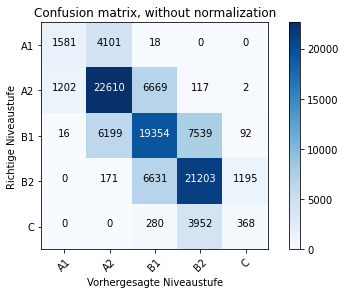

Normalized confusion matrix


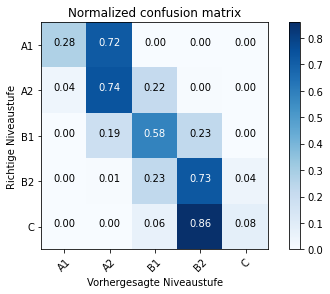

In [32]:
##### PoS-Embedding
great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])
for i in tqdm(range(100)):
  predicted_targets, true_targets, acc, kappa = evaluate_model(input, target,'knn')
  great_acc.append(acc)
  great_kappa.append(kappa)
  all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
  all_true_targets = np.append(all_true_targets, true_targets)
pos = {'name': 'pos',
             'acc':mean(great_acc),
             'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

#Wort Embeddings

In [33]:
vocab_size = 10000

In [34]:
################ Texte aufbereiten #########################

#Vokabular mit Tokenizer erstellen
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, )
tokenizer.fit_on_texts(l_texts)
word_index = tokenizer.word_index

#Texte in integer umwandeln und auf einheiliche Länge bringen
text_sequences = tokenizer.texts_to_sequences(l_texts)
input = pad_sequences(text_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1821 - accuracy: 0.5210
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8817 - accuracy: 0.6405
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7175 - accuracy: 0.7051
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4863 - accuracy: 0.8192
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3203 - accuracy: 0.8924
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2098 - accuracy: 0.9257
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1307 - accuracy: 0.9602
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0599 - accuracy: 0.9839
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0577 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0338 - accuracy: 0.9935
Epoch 1/1

  1%|          | 1/100 [01:41<2:46:39, 101.01s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1958 - accuracy: 0.4984
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8920 - accuracy: 0.6308
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7082 - accuracy: 0.7137
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4708 - accuracy: 0.8288
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3137 - accuracy: 0.8805
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1741 - accuracy: 0.9462
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1140 - accuracy: 0.9591
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1343 - accuracy: 0.9526
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0606 - accuracy: 0.9860
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0272 - accuracy: 0.9946
Epoch 1/1

  2%|▏         | 2/100 [03:19<2:42:19, 99.38s/it] 

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.2058 - accuracy: 0.5135
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9016 - accuracy: 0.6372
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6586 - accuracy: 0.7330
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5188 - accuracy: 0.8192
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3212 - accuracy: 0.8751
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1689 - accuracy: 0.9505
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1594 - accuracy: 0.9516
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1030 - accuracy: 0.9677
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0573 - accuracy: 0.9860
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0232 - accuracy: 0.9935
Epoch 1/1

  3%|▎         | 3/100 [04:50<2:34:59, 95.87s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1867 - accuracy: 0.5124
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9236 - accuracy: 0.6168
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7347 - accuracy: 0.7320
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4917 - accuracy: 0.8192
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3319 - accuracy: 0.8805
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2328 - accuracy: 0.9128
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1452 - accuracy: 0.9559
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1452 - accuracy: 0.9440
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1151 - accuracy: 0.9548
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0706 - accuracy: 0.9806
Epoch 1/1

  4%|▍         | 4/100 [06:38<2:41:00, 100.63s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.2284 - accuracy: 0.4682
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9258 - accuracy: 0.6050
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7362 - accuracy: 0.7115
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5635 - accuracy: 0.7815
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3723 - accuracy: 0.8611
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2151 - accuracy: 0.9236
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1579 - accuracy: 0.9462
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1432 - accuracy: 0.9494
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0861 - accuracy: 0.9763
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0502 - accuracy: 0.9871
Epoch 1/1

  5%|▌         | 5/100 [08:00<2:28:37, 93.87s/it] 

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.2067 - accuracy: 0.5070
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9488 - accuracy: 0.6233
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7275 - accuracy: 0.7223
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5058 - accuracy: 0.8149
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3514 - accuracy: 0.8676
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2358 - accuracy: 0.9128
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1538 - accuracy: 0.9462
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0878 - accuracy: 0.9752
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0650 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0423 - accuracy: 0.9882
Epoch 1/1

  6%|▌         | 6/100 [09:29<2:24:21, 92.14s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.2212 - accuracy: 0.5124
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9124 - accuracy: 0.6039
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7211 - accuracy: 0.7029
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5009 - accuracy: 0.8245
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2967 - accuracy: 0.9074
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1840 - accuracy: 0.9397
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1277 - accuracy: 0.9569
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1218 - accuracy: 0.9591
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0983 - accuracy: 0.9752
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0639 - accuracy: 0.9817
Epoch 1/1

  7%|▋         | 7/100 [11:10<2:27:32, 95.19s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1608 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8867 - accuracy: 0.6329
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7158 - accuracy: 0.7083
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4780 - accuracy: 0.8235
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3024 - accuracy: 0.8848
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2396 - accuracy: 0.9107
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1565 - accuracy: 0.9419
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1397 - accuracy: 0.9591
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0665 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0252 - accuracy: 0.9968
Epoch 1/1

  8%|▊         | 8/100 [12:58<2:32:11, 99.26s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1715 - accuracy: 0.5178
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8897 - accuracy: 0.6609
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7305 - accuracy: 0.7255
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4723 - accuracy: 0.8181
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2909 - accuracy: 0.8956
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1831 - accuracy: 0.9365
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1524 - accuracy: 0.9526
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1119 - accuracy: 0.9612
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0629 - accuracy: 0.9795
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0614 - accuracy: 0.9839
Epoch 1/1

  9%|▉         | 9/100 [14:40<2:31:32, 99.92s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1913 - accuracy: 0.5178
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8921 - accuracy: 0.6340
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6763 - accuracy: 0.7223
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4553 - accuracy: 0.8450
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2777 - accuracy: 0.9074
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2183 - accuracy: 0.9300
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1515 - accuracy: 0.9494
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1179 - accuracy: 0.9699
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0656 - accuracy: 0.9795
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0367 - accuracy: 0.9903
Epoch 1/1

 10%|█         | 10/100 [16:28<2:33:48, 102.54s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1951 - accuracy: 0.4984
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8913 - accuracy: 0.6211
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6904 - accuracy: 0.7277
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4560 - accuracy: 0.8407
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2827 - accuracy: 0.8924
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1966 - accuracy: 0.9279
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1460 - accuracy: 0.9494
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0888 - accuracy: 0.9666
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0655 - accuracy: 0.9828
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0433 - accuracy: 0.9892
Epoch 1/1

 11%|█         | 11/100 [18:07<2:30:17, 101.32s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1783 - accuracy: 0.5102
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9142 - accuracy: 0.6265
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7114 - accuracy: 0.7083
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4796 - accuracy: 0.8116
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3064 - accuracy: 0.8859
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2465 - accuracy: 0.9139
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1113 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1137 - accuracy: 0.9623
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1079 - accuracy: 0.9591
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0591 - accuracy: 0.9828
Epoch 1/1

 12%|█▏        | 12/100 [19:35<2:22:38, 97.26s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1511 - accuracy: 0.5339
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8715 - accuracy: 0.6491
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6870 - accuracy: 0.7363
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4862 - accuracy: 0.8224
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2794 - accuracy: 0.8999
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1767 - accuracy: 0.9462
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1167 - accuracy: 0.9548
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0919 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0847 - accuracy: 0.9752
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0347 - accuracy: 0.9925
Epoch 1/1

 13%|█▎        | 13/100 [21:18<2:23:49, 99.18s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1634 - accuracy: 0.5307
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8828 - accuracy: 0.6276
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7172 - accuracy: 0.7061
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4909 - accuracy: 0.8116
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3467 - accuracy: 0.8665
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1987 - accuracy: 0.9397
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1193 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1597 - accuracy: 0.9462
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0939 - accuracy: 0.9763
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0944 - accuracy: 0.9666
Epoch 1/1

 14%|█▍        | 14/100 [22:55<2:21:04, 98.43s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1507 - accuracy: 0.5156
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8748 - accuracy: 0.6437
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6777 - accuracy: 0.7363
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4580 - accuracy: 0.8375
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3097 - accuracy: 0.8913
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1810 - accuracy: 0.9322
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1058 - accuracy: 0.9699
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1340 - accuracy: 0.9548
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1059 - accuracy: 0.9677
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0549 - accuracy: 0.9828
Epoch 1/1

 15%|█▌        | 15/100 [24:48<2:25:44, 102.87s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1656 - accuracy: 0.5350
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9023 - accuracy: 0.6297
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6989 - accuracy: 0.7330
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4703 - accuracy: 0.8353
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3174 - accuracy: 0.8784
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1978 - accuracy: 0.9311
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1509 - accuracy: 0.9483
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0899 - accuracy: 0.9699
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0755 - accuracy: 0.9763
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0374 - accuracy: 0.9925
Epoch 1/1

 16%|█▌        | 16/100 [26:30<2:23:34, 102.55s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.2074 - accuracy: 0.4865
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9244 - accuracy: 0.6146
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7003 - accuracy: 0.7115
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5003 - accuracy: 0.8105
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2960 - accuracy: 0.8891
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2034 - accuracy: 0.9322
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1052 - accuracy: 0.9709
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0674 - accuracy: 0.9795
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1151 - accuracy: 0.9634
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0489 - accuracy: 0.9849
Epoch 1/1

 17%|█▋        | 17/100 [28:00<2:16:33, 98.72s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.2035 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9257 - accuracy: 0.5996
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7150 - accuracy: 0.7029
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5369 - accuracy: 0.8030
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3717 - accuracy: 0.8611
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2352 - accuracy: 0.9247
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1310 - accuracy: 0.9591
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0997 - accuracy: 0.9688
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0914 - accuracy: 0.9688
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0448 - accuracy: 0.9914
Epoch 1/1

 18%|█▊        | 18/100 [29:42<2:16:11, 99.65s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1742 - accuracy: 0.5199
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8908 - accuracy: 0.6426
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6993 - accuracy: 0.7040
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5174 - accuracy: 0.8127
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3098 - accuracy: 0.8924
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1573 - accuracy: 0.9569
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1102 - accuracy: 0.9677
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0970 - accuracy: 0.9699
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0583 - accuracy: 0.9860
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0410 - accuracy: 0.9892
Epoch 1/1

 19%|█▉        | 19/100 [31:12<2:10:35, 96.74s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1597 - accuracy: 0.5253
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9148 - accuracy: 0.6168
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7365 - accuracy: 0.7061
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5677 - accuracy: 0.7858
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3342 - accuracy: 0.8784
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2336 - accuracy: 0.9171
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1661 - accuracy: 0.9397
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1491 - accuracy: 0.9548
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0685 - accuracy: 0.9828
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0610 - accuracy: 0.9839
Epoch 1/1

 20%|██        | 20/100 [32:40<2:05:37, 94.22s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1611 - accuracy: 0.5178
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8871 - accuracy: 0.6448
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6875 - accuracy: 0.7309
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4914 - accuracy: 0.8105
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3243 - accuracy: 0.8730
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2053 - accuracy: 0.9290
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1565 - accuracy: 0.9451
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2007 - accuracy: 0.9343
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0730 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0432 - accuracy: 0.9871
Epoch 1/1

 21%|██        | 21/100 [34:20<2:06:12, 95.86s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1918 - accuracy: 0.4995
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9050 - accuracy: 0.6243
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7004 - accuracy: 0.7158
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5281 - accuracy: 0.8030
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3184 - accuracy: 0.8870
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1796 - accuracy: 0.9462
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1297 - accuracy: 0.9569
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0850 - accuracy: 0.9699
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1183 - accuracy: 0.9569
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3089 - accuracy: 0.9214
Epoch 1/1

 22%|██▏       | 22/100 [35:53<2:03:30, 95.01s/it]

Epoch 1/10
47/47 [==============================] - 4s 12ms/step - loss: 1.1534 - accuracy: 0.5339
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9094 - accuracy: 0.6211
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6924 - accuracy: 0.7341
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5122 - accuracy: 0.8127
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3268 - accuracy: 0.8913
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1983 - accuracy: 0.9440
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1093 - accuracy: 0.9612
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1330 - accuracy: 0.9526
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0511 - accuracy: 0.9871
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0184 - accuracy: 0.9978
Epoch 1/1

 23%|██▎       | 23/100 [37:37<2:05:26, 97.75s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1813 - accuracy: 0.4952
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8935 - accuracy: 0.6351
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7078 - accuracy: 0.7126
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4834 - accuracy: 0.8353
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3250 - accuracy: 0.8967
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1783 - accuracy: 0.9333
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1167 - accuracy: 0.9656
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1281 - accuracy: 0.9548
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0803 - accuracy: 0.9763
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0515 - accuracy: 0.9839
Epoch 1/1

 24%|██▍       | 24/100 [39:03<1:59:35, 94.42s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1450 - accuracy: 0.5339
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8882 - accuracy: 0.6394
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7442 - accuracy: 0.7018
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4845 - accuracy: 0.8256
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2841 - accuracy: 0.9031
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1828 - accuracy: 0.9365
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1568 - accuracy: 0.9462
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1231 - accuracy: 0.9569
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0673 - accuracy: 0.9795
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0555 - accuracy: 0.9860
Epoch 1/1

 25%|██▌       | 25/100 [40:37<1:57:36, 94.09s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1661 - accuracy: 0.5048
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8651 - accuracy: 0.6340
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6969 - accuracy: 0.7223
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4691 - accuracy: 0.8385
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3159 - accuracy: 0.8924
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1925 - accuracy: 0.9386
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1044 - accuracy: 0.9699
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0688 - accuracy: 0.9806
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0741 - accuracy: 0.9720
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0479 - accuracy: 0.9839
Epoch 1/1

 26%|██▌       | 26/100 [42:26<2:01:31, 98.54s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1409 - accuracy: 0.5242
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9015 - accuracy: 0.6211
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6963 - accuracy: 0.7061
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4767 - accuracy: 0.8321
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2908 - accuracy: 0.9064
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2029 - accuracy: 0.9343
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1094 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0641 - accuracy: 0.9785
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0684 - accuracy: 0.9731
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0777 - accuracy: 0.9763
Epoch 1/1

 27%|██▋       | 27/100 [44:08<2:01:15, 99.66s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1630 - accuracy: 0.5145
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8860 - accuracy: 0.6523
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6837 - accuracy: 0.7201
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4765 - accuracy: 0.8375
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3086 - accuracy: 0.8816
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2148 - accuracy: 0.9311
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1228 - accuracy: 0.9612
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1298 - accuracy: 0.9623
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2125 - accuracy: 0.9268
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0579 - accuracy: 0.9839
Epoch 1/1

 28%|██▊       | 28/100 [45:48<1:59:35, 99.67s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1730 - accuracy: 0.5124
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9360 - accuracy: 0.6243
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7289 - accuracy: 0.6878
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5093 - accuracy: 0.8105
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3440 - accuracy: 0.8794
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2686 - accuracy: 0.9107
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2290 - accuracy: 0.9300
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1292 - accuracy: 0.9623
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0841 - accuracy: 0.9774
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0811 - accuracy: 0.9742
Epoch 1/1

 29%|██▉       | 29/100 [47:26<1:57:19, 99.15s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1296 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8718 - accuracy: 0.6394
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6718 - accuracy: 0.7169
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4431 - accuracy: 0.8428
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3053 - accuracy: 0.8934
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1792 - accuracy: 0.9429
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0990 - accuracy: 0.9720
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0572 - accuracy: 0.9806
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0589 - accuracy: 0.9828
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1710 - accuracy: 0.9343
Epoch 1/1

 30%|███       | 30/100 [48:56<1:52:37, 96.53s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1582 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8969 - accuracy: 0.6469
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7033 - accuracy: 0.7191
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4741 - accuracy: 0.8342
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2951 - accuracy: 0.9053
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2211 - accuracy: 0.9257
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1562 - accuracy: 0.9505
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0966 - accuracy: 0.9709
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1139 - accuracy: 0.9612
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0692 - accuracy: 0.9806
Epoch 1/1

 31%|███       | 31/100 [50:21<1:46:53, 92.96s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1753 - accuracy: 0.4995
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8748 - accuracy: 0.6329
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6679 - accuracy: 0.7147
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4889 - accuracy: 0.8224
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2682 - accuracy: 0.9010
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1701 - accuracy: 0.9451
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1151 - accuracy: 0.9666
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0734 - accuracy: 0.9709
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0585 - accuracy: 0.9828
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0513 - accuracy: 0.9849
Epoch 1/1

 32%|███▏      | 32/100 [51:52<1:44:44, 92.42s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1824 - accuracy: 0.4801
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9178 - accuracy: 0.6265
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7169 - accuracy: 0.7191
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4997 - accuracy: 0.8159
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3295 - accuracy: 0.8751
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2031 - accuracy: 0.9300
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1423 - accuracy: 0.9505
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0956 - accuracy: 0.9752
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0508 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0346 - accuracy: 0.9849
Epoch 1/1

 33%|███▎      | 33/100 [53:25<1:43:33, 92.74s/it]

Epoch 1/10
47/47 [==============================] - 4s 12ms/step - loss: 1.2145 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9188 - accuracy: 0.6426
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7032 - accuracy: 0.7341
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5123 - accuracy: 0.8116
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3541 - accuracy: 0.8665
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2383 - accuracy: 0.9150
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1089 - accuracy: 0.9731
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0746 - accuracy: 0.9752
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0737 - accuracy: 0.9795
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1097 - accuracy: 0.9699
Epoch 1/1

 34%|███▍      | 34/100 [55:14<1:47:22, 97.61s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1753 - accuracy: 0.5414
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9112 - accuracy: 0.6125
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6778 - accuracy: 0.7212
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4621 - accuracy: 0.8332
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2926 - accuracy: 0.8999
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1955 - accuracy: 0.9322
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1053 - accuracy: 0.9688
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0687 - accuracy: 0.9828
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1391 - accuracy: 0.9516
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1003 - accuracy: 0.9688
Epoch 1/1

 35%|███▌      | 35/100 [56:50<1:45:07, 97.03s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0954 - accuracy: 0.5630
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8808 - accuracy: 0.6566
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6385 - accuracy: 0.7470
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4723 - accuracy: 0.8299
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2884 - accuracy: 0.8999
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1441 - accuracy: 0.9526
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1341 - accuracy: 0.9548
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0978 - accuracy: 0.9656
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0607 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0279 - accuracy: 0.9925
Epoch 1/1

 36%|███▌      | 36/100 [58:19<1:41:03, 94.75s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.2044 - accuracy: 0.5016
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8718 - accuracy: 0.6480
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6750 - accuracy: 0.7244
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4263 - accuracy: 0.8493
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2691 - accuracy: 0.9085
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1621 - accuracy: 0.9526
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1196 - accuracy: 0.9612
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1090 - accuracy: 0.9666
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0495 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0431 - accuracy: 0.9882
Epoch 1/1

 37%|███▋      | 37/100 [59:55<1:39:46, 95.02s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1796 - accuracy: 0.5253
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9300 - accuracy: 0.6093
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6949 - accuracy: 0.7266
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5329 - accuracy: 0.7976
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3306 - accuracy: 0.8870
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1771 - accuracy: 0.9429
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1172 - accuracy: 0.9645
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1043 - accuracy: 0.9677
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0623 - accuracy: 0.9839
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0276 - accuracy: 0.9914
Epoch 1/1

 38%|███▊      | 38/100 [1:01:42<1:41:59, 98.70s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.2206 - accuracy: 0.5038
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9240 - accuracy: 0.6297
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6952 - accuracy: 0.6889
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4916 - accuracy: 0.8073
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3597 - accuracy: 0.8784
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2081 - accuracy: 0.9365
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1134 - accuracy: 0.9677
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1102 - accuracy: 0.9666
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0552 - accuracy: 0.9839
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0217 - accuracy: 0.9946
Epoch 1/1

 39%|███▉      | 39/100 [1:03:23<1:40:50, 99.19s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1865 - accuracy: 0.5124
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9085 - accuracy: 0.6426
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7557 - accuracy: 0.7051
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5014 - accuracy: 0.8127
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3445 - accuracy: 0.8773
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2661 - accuracy: 0.9085
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1484 - accuracy: 0.9526
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1139 - accuracy: 0.9634
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1017 - accuracy: 0.9677
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0987 - accuracy: 0.9677
Epoch 1/1

 40%|████      | 40/100 [1:04:53<1:36:25, 96.43s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1957 - accuracy: 0.5145
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8943 - accuracy: 0.6459
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6865 - accuracy: 0.7255
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4584 - accuracy: 0.8321
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2768 - accuracy: 0.8988
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1763 - accuracy: 0.9408
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1227 - accuracy: 0.9569
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0839 - accuracy: 0.9752
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0473 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0269 - accuracy: 0.9914
Epoch 1/1

 41%|████      | 41/100 [1:06:42<1:38:30, 100.18s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1634 - accuracy: 0.5124
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9287 - accuracy: 0.6329
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6970 - accuracy: 0.7223
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4864 - accuracy: 0.8321
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3846 - accuracy: 0.8622
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2139 - accuracy: 0.9257
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1311 - accuracy: 0.9559
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0928 - accuracy: 0.9731
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0657 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0448 - accuracy: 0.9882
Epoch 1/1

 42%|████▏     | 42/100 [1:08:24<1:37:34, 100.93s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1855 - accuracy: 0.5188
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8991 - accuracy: 0.6308
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6542 - accuracy: 0.7513
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4510 - accuracy: 0.8461
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2853 - accuracy: 0.8902
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2067 - accuracy: 0.9290
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1388 - accuracy: 0.9548
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0973 - accuracy: 0.9656
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1102 - accuracy: 0.9623
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0892 - accuracy: 0.9699
Epoch 1/1

 43%|████▎     | 43/100 [1:10:09<1:37:00, 102.12s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1462 - accuracy: 0.5468
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8603 - accuracy: 0.6416
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6892 - accuracy: 0.7147
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5142 - accuracy: 0.8213
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2793 - accuracy: 0.8988
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1912 - accuracy: 0.9386
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1351 - accuracy: 0.9569
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0783 - accuracy: 0.9731
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0628 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0414 - accuracy: 0.9882
Epoch 1/1

 44%|████▍     | 44/100 [1:11:35<1:30:43, 97.20s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1781 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9366 - accuracy: 0.6416
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7431 - accuracy: 0.6964
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5275 - accuracy: 0.7944
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3330 - accuracy: 0.8924
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2138 - accuracy: 0.9322
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1341 - accuracy: 0.9623
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0743 - accuracy: 0.9774
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1000 - accuracy: 0.9602
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0733 - accuracy: 0.9763
Epoch 1/1

 45%|████▌     | 45/100 [1:13:16<1:30:06, 98.31s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1650 - accuracy: 0.5339
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8862 - accuracy: 0.6545
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7194 - accuracy: 0.7147
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4709 - accuracy: 0.8256
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3021 - accuracy: 0.8837
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2261 - accuracy: 0.9139
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1768 - accuracy: 0.9343
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1459 - accuracy: 0.9451
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0851 - accuracy: 0.9763
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0571 - accuracy: 0.9806
Epoch 1/1

 46%|████▌     | 46/100 [1:15:03<1:30:55, 101.03s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1524 - accuracy: 0.5145
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8949 - accuracy: 0.6362
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7167 - accuracy: 0.7115
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5187 - accuracy: 0.8159
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4108 - accuracy: 0.8579
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2454 - accuracy: 0.9107
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1357 - accuracy: 0.9580
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1005 - accuracy: 0.9699
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1044 - accuracy: 0.9666
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0988 - accuracy: 0.9677
Epoch 1/1

 47%|████▋     | 47/100 [1:16:31<1:25:48, 97.14s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1479 - accuracy: 0.5404
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8986 - accuracy: 0.6459
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6984 - accuracy: 0.7147
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4481 - accuracy: 0.8332
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2672 - accuracy: 0.9020
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1736 - accuracy: 0.9386
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1737 - accuracy: 0.9408
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0889 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0863 - accuracy: 0.9752
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0531 - accuracy: 0.9860
Epoch 1/1

 48%|████▊     | 48/100 [1:18:06<1:23:29, 96.34s/it]

Epoch 1/10
47/47 [==============================] - 4s 12ms/step - loss: 1.1825 - accuracy: 0.4995
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9178 - accuracy: 0.6437
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6960 - accuracy: 0.7201
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5102 - accuracy: 0.8127
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3258 - accuracy: 0.8805
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1831 - accuracy: 0.9354
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1023 - accuracy: 0.9720
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0989 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0521 - accuracy: 0.9860
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0241 - accuracy: 0.9946
Epoch 1/1

 49%|████▉     | 49/100 [1:19:51<1:24:07, 98.96s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1466 - accuracy: 0.5479
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8674 - accuracy: 0.6383
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6691 - accuracy: 0.7298
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5093 - accuracy: 0.8149
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2812 - accuracy: 0.9074
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1609 - accuracy: 0.9505
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1424 - accuracy: 0.9494
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0769 - accuracy: 0.9731
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1212 - accuracy: 0.9537
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0539 - accuracy: 0.9817
Epoch 1/1

 50%|█████     | 50/100 [1:21:40<1:25:05, 102.11s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1781 - accuracy: 0.5156
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9271 - accuracy: 0.6157
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7167 - accuracy: 0.7137
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5367 - accuracy: 0.8105
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3275 - accuracy: 0.8870
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2351 - accuracy: 0.9236
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1306 - accuracy: 0.9612
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1231 - accuracy: 0.9645
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0686 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0412 - accuracy: 0.9871
Epoch 1/1

 51%|█████     | 51/100 [1:23:24<1:23:45, 102.56s/it]

Epoch 1/10
47/47 [==============================] - 2s 14ms/step - loss: 1.2292 - accuracy: 0.5016
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9288 - accuracy: 0.6114
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7254 - accuracy: 0.7094
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4922 - accuracy: 0.8041
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3067 - accuracy: 0.8977
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2099 - accuracy: 0.9236
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1853 - accuracy: 0.9365
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1256 - accuracy: 0.9537
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0574 - accuracy: 0.9817
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0365 - accuracy: 0.9903
Epoch 1/1

 52%|█████▏    | 52/100 [1:25:05<1:21:40, 102.08s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1674 - accuracy: 0.5135
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9385 - accuracy: 0.6071
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7316 - accuracy: 0.7018
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4678 - accuracy: 0.8267
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3630 - accuracy: 0.8687
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2123 - accuracy: 0.9322
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1404 - accuracy: 0.9440
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0755 - accuracy: 0.9795
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0753 - accuracy: 0.9763
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0491 - accuracy: 0.9849
Epoch 1/1

 53%|█████▎    | 53/100 [1:26:48<1:20:14, 102.43s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.2093 - accuracy: 0.4919
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9027 - accuracy: 0.6136
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7396 - accuracy: 0.7104
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4913 - accuracy: 0.8138
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3080 - accuracy: 0.8999
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1815 - accuracy: 0.9462
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1356 - accuracy: 0.9591
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0823 - accuracy: 0.9774
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0744 - accuracy: 0.9763
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0503 - accuracy: 0.9817
Epoch 1/1

 54%|█████▍    | 54/100 [1:28:42<1:21:12, 105.93s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1944 - accuracy: 0.4984
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9163 - accuracy: 0.6093
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7111 - accuracy: 0.7147
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4910 - accuracy: 0.8138
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2812 - accuracy: 0.8924
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1988 - accuracy: 0.9236
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1125 - accuracy: 0.9688
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0710 - accuracy: 0.9763
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0490 - accuracy: 0.9839
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1168 - accuracy: 0.9612
Epoch 1/1

 55%|█████▌    | 55/100 [1:30:26<1:18:53, 105.18s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1563 - accuracy: 0.5167
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9021 - accuracy: 0.6329
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6913 - accuracy: 0.7072
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4744 - accuracy: 0.8288
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3010 - accuracy: 0.8956
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1728 - accuracy: 0.9473
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1176 - accuracy: 0.9623
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1092 - accuracy: 0.9623
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0795 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0393 - accuracy: 0.9914
Epoch 1/1

 56%|█████▌    | 56/100 [1:32:11<1:17:17, 105.39s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1668 - accuracy: 0.5210
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8758 - accuracy: 0.6437
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7512 - accuracy: 0.7094
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4738 - accuracy: 0.8321
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2838 - accuracy: 0.8999
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1874 - accuracy: 0.9311
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2060 - accuracy: 0.9365
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0777 - accuracy: 0.9774
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0565 - accuracy: 0.9860
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0422 - accuracy: 0.9860
Epoch 1/1

 57%|█████▋    | 57/100 [1:33:47<1:13:23, 102.42s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2070 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9241 - accuracy: 0.5996
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7323 - accuracy: 0.7169
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4830 - accuracy: 0.8224
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2820 - accuracy: 0.8988
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1699 - accuracy: 0.9397
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1030 - accuracy: 0.9699
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0633 - accuracy: 0.9795
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0931 - accuracy: 0.9645
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1068 - accuracy: 0.9634
Epoch 1/1

 58%|█████▊    | 58/100 [1:35:33<1:12:22, 103.39s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2258 - accuracy: 0.5371
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9319 - accuracy: 0.5856
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7313 - accuracy: 0.6878
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4921 - accuracy: 0.8288
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3225 - accuracy: 0.8827
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1769 - accuracy: 0.9429
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1131 - accuracy: 0.9666
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0942 - accuracy: 0.9709
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0622 - accuracy: 0.9817
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0568 - accuracy: 0.9774
Epoch 1/1

 59%|█████▉    | 59/100 [1:37:08<1:09:01, 101.02s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1657 - accuracy: 0.5178
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9628 - accuracy: 0.6146
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7463 - accuracy: 0.6943
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5228 - accuracy: 0.8073
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3060 - accuracy: 0.8999
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2146 - accuracy: 0.9343
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1929 - accuracy: 0.9290
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1565 - accuracy: 0.9473
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0712 - accuracy: 0.9828
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0448 - accuracy: 0.9892
Epoch 1/1

 60%|██████    | 60/100 [1:38:41<1:05:48, 98.72s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1699 - accuracy: 0.5361
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8902 - accuracy: 0.6502
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6934 - accuracy: 0.7169
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4530 - accuracy: 0.8267
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3035 - accuracy: 0.8999
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1869 - accuracy: 0.9343
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1024 - accuracy: 0.9720
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1064 - accuracy: 0.9666
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0604 - accuracy: 0.9871
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0277 - accuracy: 0.9903
Epoch 1/1

 61%|██████    | 61/100 [1:40:13<1:02:46, 96.58s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.2044 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9047 - accuracy: 0.6372
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7524 - accuracy: 0.7029
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4859 - accuracy: 0.8084
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3195 - accuracy: 0.8816
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1951 - accuracy: 0.9408
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1178 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1680 - accuracy: 0.9451
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0805 - accuracy: 0.9763
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0322 - accuracy: 0.9903
Epoch 1/1

 62%|██████▏   | 62/100 [1:41:51<1:01:21, 96.87s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1560 - accuracy: 0.5318
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8989 - accuracy: 0.6459
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7171 - accuracy: 0.7277
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5145 - accuracy: 0.8009
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3228 - accuracy: 0.8762
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2612 - accuracy: 0.9139
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1714 - accuracy: 0.9440
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.9548
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0978 - accuracy: 0.9656
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0645 - accuracy: 0.9828
Epoch 1/1

 63%|██████▎   | 63/100 [1:43:26<59:31, 96.52s/it]  

Epoch 1/10
47/47 [==============================] - 4s 13ms/step - loss: 1.1783 - accuracy: 0.4909
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8866 - accuracy: 0.6469
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7084 - accuracy: 0.7395
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4622 - accuracy: 0.8407
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3366 - accuracy: 0.8902
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1860 - accuracy: 0.9322
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1053 - accuracy: 0.9688
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1254 - accuracy: 0.9612
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0587 - accuracy: 0.9871
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0416 - accuracy: 0.9795
Epoch 1/1

 64%|██████▍   | 64/100 [1:45:08<58:53, 98.15s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1464 - accuracy: 0.5479
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8570 - accuracy: 0.6566
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6239 - accuracy: 0.7578
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4003 - accuracy: 0.8590
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2277 - accuracy: 0.9247
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1488 - accuracy: 0.9559
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1416 - accuracy: 0.9505
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0622 - accuracy: 0.9806
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0522 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0373 - accuracy: 0.9892
Epoch 1/1

 65%|██████▌   | 65/100 [1:46:42<56:29, 96.83s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2228 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9279 - accuracy: 0.5823
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7880 - accuracy: 0.6943
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5302 - accuracy: 0.8084
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3111 - accuracy: 0.8837
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2048 - accuracy: 0.9343
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1594 - accuracy: 0.9451
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0974 - accuracy: 0.9742
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0646 - accuracy: 0.9828
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0455 - accuracy: 0.9849
Epoch 1/1

 66%|██████▌   | 66/100 [1:48:26<56:03, 98.94s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1910 - accuracy: 0.5285
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8637 - accuracy: 0.6448
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7148 - accuracy: 0.6997
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4806 - accuracy: 0.8256
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3310 - accuracy: 0.8676
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2046 - accuracy: 0.9386
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1023 - accuracy: 0.9742
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1295 - accuracy: 0.9569
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0921 - accuracy: 0.9731
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0463 - accuracy: 0.9892
Epoch 1/1

 67%|██████▋   | 67/100 [1:49:52<52:15, 95.01s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1553 - accuracy: 0.5479
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9579 - accuracy: 0.6222
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7003 - accuracy: 0.7137
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4971 - accuracy: 0.8192
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3434 - accuracy: 0.8848
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2393 - accuracy: 0.9300
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1513 - accuracy: 0.9580
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1049 - accuracy: 0.9666
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1008 - accuracy: 0.9688
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0883 - accuracy: 0.9763
Epoch 1/1

 68%|██████▊   | 68/100 [1:51:36<52:08, 97.77s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1775 - accuracy: 0.5156
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9158 - accuracy: 0.6093
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7022 - accuracy: 0.7137
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4549 - accuracy: 0.8375
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2929 - accuracy: 0.8913
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1826 - accuracy: 0.9322
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1305 - accuracy: 0.9559
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0972 - accuracy: 0.9645
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0684 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0177 - accuracy: 0.9957
Epoch 1/1

 69%|██████▉   | 69/100 [1:53:18<51:11, 99.08s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2090 - accuracy: 0.4747
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9106 - accuracy: 0.6362
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7323 - accuracy: 0.7115
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5456 - accuracy: 0.7804
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3561 - accuracy: 0.8816
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2591 - accuracy: 0.9139
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1232 - accuracy: 0.9688
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0548 - accuracy: 0.9860
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0568 - accuracy: 0.9828
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0622 - accuracy: 0.9882
Epoch 1/1

 70%|███████   | 70/100 [1:55:03<50:21, 100.73s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1677 - accuracy: 0.5178
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8873 - accuracy: 0.6351
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6724 - accuracy: 0.7374
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4457 - accuracy: 0.8332
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2803 - accuracy: 0.9096
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1755 - accuracy: 0.9462
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1165 - accuracy: 0.9645
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1445 - accuracy: 0.9548
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0545 - accuracy: 0.9839
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0441 - accuracy: 0.9882
Epoch 1/1

 71%|███████   | 71/100 [1:56:45<48:53, 101.15s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1585 - accuracy: 0.5285
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9018 - accuracy: 0.6319
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7557 - accuracy: 0.7126
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5028 - accuracy: 0.8192
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3404 - accuracy: 0.8837
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2402 - accuracy: 0.9193
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1534 - accuracy: 0.9494
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1463 - accuracy: 0.9494
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0733 - accuracy: 0.9763
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0440 - accuracy: 0.9871
Epoch 1/1

 72%|███████▏  | 72/100 [1:58:33<48:08, 103.16s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1703 - accuracy: 0.5285
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9202 - accuracy: 0.6286
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7176 - accuracy: 0.7201
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5209 - accuracy: 0.8138
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3247 - accuracy: 0.8934
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1925 - accuracy: 0.9440
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1555 - accuracy: 0.9483
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1200 - accuracy: 0.9634
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0577 - accuracy: 0.9860
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0222 - accuracy: 0.9935
Epoch 1/1

 73%|███████▎  | 73/100 [2:00:15<46:22, 103.04s/it]

Epoch 1/10
47/47 [==============================] - 2s 15ms/step - loss: 1.2288 - accuracy: 0.5167
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9292 - accuracy: 0.6093
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7407 - accuracy: 0.7040
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5210 - accuracy: 0.8116
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3375 - accuracy: 0.8730
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2052 - accuracy: 0.9322
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.2856 - accuracy: 0.9031
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1217 - accuracy: 0.9612
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0816 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0402 - accuracy: 0.9892
Epoch 1/1

 74%|███████▍  | 74/100 [2:01:56<44:22, 102.40s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1756 - accuracy: 0.5048
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9284 - accuracy: 0.6372
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7425 - accuracy: 0.7126
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5216 - accuracy: 0.7933
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3590 - accuracy: 0.8741
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2209 - accuracy: 0.9279
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1301 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0883 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1540 - accuracy: 0.9419
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0973 - accuracy: 0.9699
Epoch 1/1

 75%|███████▌  | 75/100 [2:03:43<43:08, 103.56s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1732 - accuracy: 0.4984
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9013 - accuracy: 0.6351
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6822 - accuracy: 0.7201
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4850 - accuracy: 0.8159
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2940 - accuracy: 0.8913
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2399 - accuracy: 0.9139
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1392 - accuracy: 0.9591
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0787 - accuracy: 0.9709
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0427 - accuracy: 0.9882
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0783 - accuracy: 0.9774
Epoch 1/1

 76%|███████▌  | 76/100 [2:05:23<41:01, 102.55s/it]

Epoch 1/10
47/47 [==============================] - 4s 13ms/step - loss: 1.1929 - accuracy: 0.5188
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9293 - accuracy: 0.6297
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7177 - accuracy: 0.7212
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5532 - accuracy: 0.7944
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3430 - accuracy: 0.8730
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2212 - accuracy: 0.9214
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1784 - accuracy: 0.9365
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1196 - accuracy: 0.9602
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1064 - accuracy: 0.9656
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0946 - accuracy: 0.9720
Epoch 1/1

 77%|███████▋  | 77/100 [2:06:58<38:25, 100.25s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1546 - accuracy: 0.5447
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9204 - accuracy: 0.6480
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7421 - accuracy: 0.6954
Epoch 4/10
47/47 [==============================] - 1s 14ms/step - loss: 0.4979 - accuracy: 0.8353
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3529 - accuracy: 0.8676
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2659 - accuracy: 0.9031
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1383 - accuracy: 0.9580
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1015 - accuracy: 0.9688
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0889 - accuracy: 0.9709
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0880 - accuracy: 0.9688
Epoch 1/1

 78%|███████▊  | 78/100 [2:08:36<36:34, 99.74s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1767 - accuracy: 0.5081
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9191 - accuracy: 0.6480
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7260 - accuracy: 0.7201
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4882 - accuracy: 0.8105
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2895 - accuracy: 0.8999
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2130 - accuracy: 0.9365
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1751 - accuracy: 0.9451
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1023 - accuracy: 0.9656
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0355 - accuracy: 0.9903
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0240 - accuracy: 0.9957
Epoch 1/1

 79%|███████▉  | 79/100 [2:10:09<34:11, 97.69s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1847 - accuracy: 0.4887
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9065 - accuracy: 0.6114
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7204 - accuracy: 0.7008
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4743 - accuracy: 0.8019
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3485 - accuracy: 0.8741
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2202 - accuracy: 0.9236
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1247 - accuracy: 0.9526
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1765 - accuracy: 0.9300
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0818 - accuracy: 0.9731
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0452 - accuracy: 0.9871
Epoch 1/1

 80%|████████  | 80/100 [2:11:48<32:39, 97.96s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1670 - accuracy: 0.4930
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9108 - accuracy: 0.6340
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7550 - accuracy: 0.6943
Epoch 4/10
47/47 [==============================] - 1s 14ms/step - loss: 0.5070 - accuracy: 0.8041
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3064 - accuracy: 0.8837
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2161 - accuracy: 0.9300
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1262 - accuracy: 0.9569
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0771 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0781 - accuracy: 0.9709
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0627 - accuracy: 0.9795
Epoch 1/1

 81%|████████  | 81/100 [2:13:32<31:38, 99.90s/it]

Epoch 1/10
47/47 [==============================] - 2s 14ms/step - loss: 1.1761 - accuracy: 0.5048
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8751 - accuracy: 0.6534
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6662 - accuracy: 0.7266
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4194 - accuracy: 0.8568
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2628 - accuracy: 0.9064
Epoch 6/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1790 - accuracy: 0.9365
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1712 - accuracy: 0.9365
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0512 - accuracy: 0.9892
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0349 - accuracy: 0.9839
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0405 - accuracy: 0.9871
Epoch 1/1

 82%|████████▏ | 82/100 [2:15:07<29:31, 98.43s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2089 - accuracy: 0.5016
Epoch 2/10
47/47 [==============================] - 1s 14ms/step - loss: 0.8978 - accuracy: 0.6416
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7184 - accuracy: 0.7180
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5027 - accuracy: 0.8224
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3224 - accuracy: 0.8945
Epoch 6/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1817 - accuracy: 0.9462
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0830 - accuracy: 0.9763
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0611 - accuracy: 0.9860
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0623 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1278 - accuracy: 0.9602
Epoch 1/1

 83%|████████▎ | 83/100 [2:16:48<28:05, 99.16s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1962 - accuracy: 0.5016
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8940 - accuracy: 0.6254
Epoch 3/10
47/47 [==============================] - 1s 14ms/step - loss: 0.7411 - accuracy: 0.6997
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4594 - accuracy: 0.8235
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2635 - accuracy: 0.9096
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2143 - accuracy: 0.9214
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1213 - accuracy: 0.9591
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0678 - accuracy: 0.9817
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0364 - accuracy: 0.9903
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0216 - accuracy: 0.9968
Epoch 1/1

 84%|████████▍ | 84/100 [2:18:31<26:45, 100.32s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1850 - accuracy: 0.5178
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9149 - accuracy: 0.6448
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7296 - accuracy: 0.7234
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5072 - accuracy: 0.8159
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3257 - accuracy: 0.8837
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2525 - accuracy: 0.9074
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1597 - accuracy: 0.9494
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0859 - accuracy: 0.9688
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0806 - accuracy: 0.9709
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0998 - accuracy: 0.9677
Epoch 1/1

 85%|████████▌ | 85/100 [2:20:08<24:48, 99.26s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2156 - accuracy: 0.5070
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9407 - accuracy: 0.6017
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7513 - accuracy: 0.6954
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4898 - accuracy: 0.8181
Epoch 5/10
47/47 [==============================] - 1s 14ms/step - loss: 0.3396 - accuracy: 0.8827
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2073 - accuracy: 0.9343
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1401 - accuracy: 0.9516
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0926 - accuracy: 0.9677
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0674 - accuracy: 0.9828
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0631 - accuracy: 0.9849
Epoch 1/1

 86%|████████▌ | 86/100 [2:21:58<23:57, 102.68s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1748 - accuracy: 0.5404
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8623 - accuracy: 0.6480
Epoch 3/10
47/47 [==============================] - 1s 14ms/step - loss: 0.6832 - accuracy: 0.7158
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4242 - accuracy: 0.8461
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2844 - accuracy: 0.9085
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1737 - accuracy: 0.9462
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1068 - accuracy: 0.9688
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0777 - accuracy: 0.9774
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0814 - accuracy: 0.9742
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0490 - accuracy: 0.9849
Epoch 1/1

 87%|████████▋ | 87/100 [2:23:47<22:38, 104.46s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1587 - accuracy: 0.5414
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9109 - accuracy: 0.6351
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7615 - accuracy: 0.6868
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5859 - accuracy: 0.7761
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4013 - accuracy: 0.8504
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2318 - accuracy: 0.9290
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1658 - accuracy: 0.9429
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1006 - accuracy: 0.9709
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0527 - accuracy: 0.9871
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0255 - accuracy: 0.9925
Epoch 1/1

 88%|████████▊ | 88/100 [2:25:26<20:34, 102.86s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1914 - accuracy: 0.5264
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9037 - accuracy: 0.6491
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7480 - accuracy: 0.6943
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5093 - accuracy: 0.8073
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3142 - accuracy: 0.8805
Epoch 6/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1876 - accuracy: 0.9279
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1349 - accuracy: 0.9612
Epoch 8/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0659 - accuracy: 0.9806
Epoch 9/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0696 - accuracy: 0.9795
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1502 - accuracy: 0.9516
Epoch 1/1

 89%|████████▉ | 89/100 [2:27:04<18:35, 101.37s/it]

Epoch 1/10
47/47 [==============================] - 2s 14ms/step - loss: 1.1930 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 14ms/step - loss: 0.9327 - accuracy: 0.6103
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7299 - accuracy: 0.7094
Epoch 4/10
47/47 [==============================] - 1s 14ms/step - loss: 0.5260 - accuracy: 0.8159
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3038 - accuracy: 0.8977
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1682 - accuracy: 0.9505
Epoch 7/10
47/47 [==============================] - 1s 15ms/step - loss: 0.1310 - accuracy: 0.9580
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0629 - accuracy: 0.9860
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0483 - accuracy: 0.9871
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0983 - accuracy: 0.9645
Epoch 1/1

 90%|█████████ | 90/100 [2:28:39<16:35, 99.56s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1608 - accuracy: 0.5167
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8581 - accuracy: 0.6609
Epoch 3/10
47/47 [==============================] - 1s 14ms/step - loss: 0.6495 - accuracy: 0.7341
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4751 - accuracy: 0.8299
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3249 - accuracy: 0.8773
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2167 - accuracy: 0.9279
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1328 - accuracy: 0.9537
Epoch 8/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0968 - accuracy: 0.9731
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0516 - accuracy: 0.9871
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0593 - accuracy: 0.9849
Epoch 1/1

 91%|█████████ | 91/100 [2:30:21<15:02, 100.23s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1831 - accuracy: 0.4984
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8877 - accuracy: 0.6394
Epoch 3/10
47/47 [==============================] - 1s 14ms/step - loss: 0.7084 - accuracy: 0.6986
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4826 - accuracy: 0.8192
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3529 - accuracy: 0.8719
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2139 - accuracy: 0.9279
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1388 - accuracy: 0.9602
Epoch 8/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0885 - accuracy: 0.9785
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0768 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0984 - accuracy: 0.9656
Epoch 1/1

 92%|█████████▏| 92/100 [2:32:08<13:38, 102.31s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1918 - accuracy: 0.5005
Epoch 2/10
47/47 [==============================] - 1s 14ms/step - loss: 0.9777 - accuracy: 0.5834
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7695 - accuracy: 0.6695
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5497 - accuracy: 0.7890
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3430 - accuracy: 0.8751
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2572 - accuracy: 0.9128
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2059 - accuracy: 0.9257
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1318 - accuracy: 0.9580
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1083 - accuracy: 0.9602
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0683 - accuracy: 0.9795
Epoch 1/1

 93%|█████████▎| 93/100 [2:33:55<12:06, 103.72s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1893 - accuracy: 0.4898
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9129 - accuracy: 0.6179
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7805 - accuracy: 0.6975
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5564 - accuracy: 0.7847
Epoch 5/10
47/47 [==============================] - 1s 14ms/step - loss: 0.3480 - accuracy: 0.8805
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1919 - accuracy: 0.9397
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1147 - accuracy: 0.9602
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0923 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1039 - accuracy: 0.9645
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0907 - accuracy: 0.9634
Epoch 1/1

 94%|█████████▍| 94/100 [2:35:41<10:26, 104.36s/it]

Epoch 1/10
47/47 [==============================] - 2s 14ms/step - loss: 1.1708 - accuracy: 0.5307
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9189 - accuracy: 0.6297
Epoch 3/10
47/47 [==============================] - 1s 14ms/step - loss: 0.7327 - accuracy: 0.7212
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5065 - accuracy: 0.8116
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3088 - accuracy: 0.8988
Epoch 6/10
47/47 [==============================] - 1s 15ms/step - loss: 0.1973 - accuracy: 0.9311
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1532 - accuracy: 0.9516
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0780 - accuracy: 0.9785
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0529 - accuracy: 0.9839
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1165 - accuracy: 0.9612
Epoch 1/1

 95%|█████████▌| 95/100 [2:37:25<08:41, 104.28s/it]

Epoch 1/10
47/47 [==============================] - 2s 14ms/step - loss: 1.1305 - accuracy: 0.5554
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9462 - accuracy: 0.6050
Epoch 3/10
47/47 [==============================] - 1s 14ms/step - loss: 0.7043 - accuracy: 0.7094
Epoch 4/10
47/47 [==============================] - 1s 14ms/step - loss: 0.5065 - accuracy: 0.8105
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2966 - accuracy: 0.9042
Epoch 6/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1494 - accuracy: 0.9569
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1169 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0734 - accuracy: 0.9774
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1561 - accuracy: 0.9451
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0685 - accuracy: 0.9839
Epoch 1/1

 96%|█████████▌| 96/100 [2:39:07<06:53, 103.49s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2236 - accuracy: 0.4758
Epoch 2/10
47/47 [==============================] - 1s 14ms/step - loss: 0.9350 - accuracy: 0.6082
Epoch 3/10
47/47 [==============================] - 1s 15ms/step - loss: 0.7648 - accuracy: 0.6954
Epoch 4/10
47/47 [==============================] - 1s 14ms/step - loss: 0.5205 - accuracy: 0.8181
Epoch 5/10
47/47 [==============================] - 1s 14ms/step - loss: 0.3400 - accuracy: 0.8881
Epoch 6/10
47/47 [==============================] - 1s 14ms/step - loss: 0.2072 - accuracy: 0.9322
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1657 - accuracy: 0.9386
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1464 - accuracy: 0.9516
Epoch 9/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0976 - accuracy: 0.9709
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0502 - accuracy: 0.9849
Epoch 1/1

 97%|█████████▋| 97/100 [2:40:40<05:01, 100.35s/it]

Epoch 1/10
47/47 [==============================] - 2s 14ms/step - loss: 1.1787 - accuracy: 0.5178
Epoch 2/10
47/47 [==============================] - 1s 14ms/step - loss: 0.9126 - accuracy: 0.6125
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6869 - accuracy: 0.7072
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5070 - accuracy: 0.8149
Epoch 5/10
47/47 [==============================] - 1s 14ms/step - loss: 0.3092 - accuracy: 0.8977
Epoch 6/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1633 - accuracy: 0.9473
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0830 - accuracy: 0.9742
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1420 - accuracy: 0.9569
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1072 - accuracy: 0.9666
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0530 - accuracy: 0.9839
Epoch 1/1

 98%|█████████▊| 98/100 [2:42:19<03:19, 99.84s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1620 - accuracy: 0.5113
Epoch 2/10
47/47 [==============================] - 1s 14ms/step - loss: 0.9168 - accuracy: 0.6276
Epoch 3/10
47/47 [==============================] - 1s 14ms/step - loss: 0.7155 - accuracy: 0.7061
Epoch 4/10
47/47 [==============================] - 1s 15ms/step - loss: 0.4916 - accuracy: 0.8278
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3165 - accuracy: 0.8902
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1513 - accuracy: 0.9505
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0933 - accuracy: 0.9688
Epoch 8/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0696 - accuracy: 0.9785
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0905 - accuracy: 0.9731
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0987 - accuracy: 0.9656
Epoch 1/1

 99%|█████████▉| 99/100 [2:44:06<01:42, 102.19s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1835 - accuracy: 0.4898
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9088 - accuracy: 0.6146
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6762 - accuracy: 0.7234
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4535 - accuracy: 0.8364
Epoch 5/10
47/47 [==============================] - 1s 14ms/step - loss: 0.2868 - accuracy: 0.9096
Epoch 6/10
47/47 [==============================] - 1s 14ms/step - loss: 0.2238 - accuracy: 0.9279
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1677 - accuracy: 0.9483
Epoch 8/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1164 - accuracy: 0.9580
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0703 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0533 - accuracy: 0.9860
Epoch 1/1

100%|██████████| 100/100 [2:45:56<00:00, 99.56s/it] 


Confusion matrix, without normalization


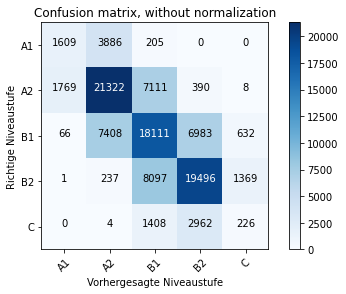

Normalized confusion matrix


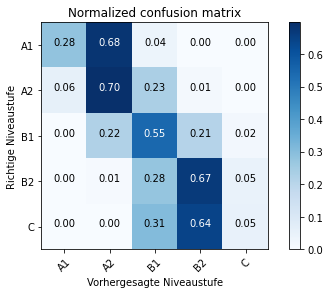

In [35]:
##### Word-Embedding
great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])
for i in tqdm(range(100)):
  predicted_targets, true_targets, acc, kappa = evaluate_model(input, target,'knn')
  great_acc.append(acc)
  great_kappa.append(kappa)
  all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
  all_true_targets = np.append(all_true_targets, true_targets)
word = {'name': 'word',
             'acc':mean(great_acc),
             'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

#Word2Vec

In [23]:
PATH = '/content/drive/MyDrive/Masterarbeit/Data'

In [24]:
vocab_size = 10000

In [25]:
%%time
de_model = KeyedVectors.load_word2vec_format(PATH + "/cc.de.300.vec") #Word2Vec Modell mit Gensim laden

CPU times: user 8min 45s, sys: 6.7 s, total: 8min 52s
Wall time: 9min 44s


In [26]:
################ Texte aufbereiten #########################

#Vokabular mit Tokenizer erstellen
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, )
tokenizer.fit_on_texts(l_texts)
word_index = tokenizer.word_index

#Texte in integer umwandeln und auf einheiliche Länge bringen
text_sequences = tokenizer.texts_to_sequences(l_texts)
input = pad_sequences(text_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [27]:
# Create embedding matrix
print("preparing embedding matrix...")
words_not_found = []
# max unique words to keep
nb_words = min(vocab_size, len(word_index))
# define matrix dimensions
embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    try:
        embedding_vector = de_model.get_vector(word)
    except KeyError:
        embedding_vector = None
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print(f"Null word embeddings: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}")
print(
    f"Some of the words not found:\n"
    f"{' '.join([random.choice(words_not_found) for x in range(0,10)])}"
)

preparing embedding matrix...
Null word embeddings: 2987
Some of the words not found:
erstesmal istanbull nordwestschweiz fraen fürrt wochenendausflus liebern aßurserdem gelont eurapischen


In [28]:
#Architektur
def knn_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(nb_words,
                      embedding_dim,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=max_length,
                      trainable=False  
  ))
  model.add(Bidirectional(GRU(embedding_dim)))
  model.add(Dense(5, activation='softmax'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy',],
  )
  return model

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1449 - accuracy: 0.5640
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8864 - accuracy: 0.6491
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7325 - accuracy: 0.7223
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5010 - accuracy: 0.8181
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3913 - accuracy: 0.8644
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2490 - accuracy: 0.9203
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1417 - accuracy: 0.9505
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1346 - accuracy: 0.9559
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0832 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0305 - accuracy: 0.9957
Epoch 1/1

  1%|          | 1/100 [01:38<2:41:45, 98.03s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1969 - accuracy: 0.5156
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8928 - accuracy: 0.6340
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6631 - accuracy: 0.7309
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4587 - accuracy: 0.8299
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3034 - accuracy: 0.8870
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1954 - accuracy: 0.9354
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1642 - accuracy: 0.9419
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0792 - accuracy: 0.9774
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0317 - accuracy: 0.9935
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0694 - accuracy: 0.9785
Epoch 1/1

  2%|▏         | 2/100 [03:13<2:37:54, 96.68s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1602 - accuracy: 0.5425
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8963 - accuracy: 0.6426
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6901 - accuracy: 0.7277
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4610 - accuracy: 0.8288
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2813 - accuracy: 0.8977
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1997 - accuracy: 0.9268
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1076 - accuracy: 0.9699
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0935 - accuracy: 0.9623
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0642 - accuracy: 0.9839
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0319 - accuracy: 0.9903
Epoch 1/1

  3%|▎         | 3/100 [04:41<2:30:00, 92.79s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1761 - accuracy: 0.5005
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9033 - accuracy: 0.6222
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7551 - accuracy: 0.6900
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5324 - accuracy: 0.8019
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3442 - accuracy: 0.8601
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1939 - accuracy: 0.9322
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1229 - accuracy: 0.9677
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0738 - accuracy: 0.9785
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0799 - accuracy: 0.9731
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0721 - accuracy: 0.9763
Epoch 1/1

  4%|▍         | 4/100 [06:22<2:33:36, 96.01s/it]

Epoch 1/10
47/47 [==============================] - 4s 11ms/step - loss: 1.1922 - accuracy: 0.4769
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9394 - accuracy: 0.6103
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7134 - accuracy: 0.7191
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4567 - accuracy: 0.8310
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2796 - accuracy: 0.8945
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2227 - accuracy: 0.9236
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1475 - accuracy: 0.9494
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0949 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0827 - accuracy: 0.9731
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0546 - accuracy: 0.9828
Epoch 1/1

  5%|▌         | 5/100 [08:06<2:36:15, 98.69s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1632 - accuracy: 0.5091
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8735 - accuracy: 0.6491
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6741 - accuracy: 0.7201
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5009 - accuracy: 0.8159
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3076 - accuracy: 0.8891
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2172 - accuracy: 0.9236
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1213 - accuracy: 0.9623
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1047 - accuracy: 0.9688
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0988 - accuracy: 0.9656
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0630 - accuracy: 0.9774
Epoch 1/1

  6%|▌         | 6/100 [09:44<2:34:27, 98.59s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1738 - accuracy: 0.5296
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9159 - accuracy: 0.6276
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7462 - accuracy: 0.7029
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5124 - accuracy: 0.7987
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3573 - accuracy: 0.8654
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2276 - accuracy: 0.9257
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1670 - accuracy: 0.9473
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1088 - accuracy: 0.9677
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0654 - accuracy: 0.9828
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0557 - accuracy: 0.9839
Epoch 1/1

  7%|▋         | 7/100 [11:30<2:36:28, 100.95s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1728 - accuracy: 0.5242
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9015 - accuracy: 0.6329
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6908 - accuracy: 0.7287
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5111 - accuracy: 0.8213
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3421 - accuracy: 0.8859
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2509 - accuracy: 0.9160
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1394 - accuracy: 0.9516
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1343 - accuracy: 0.9591
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1361 - accuracy: 0.9537
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0546 - accuracy: 0.9860
Epoch 1/1

  8%|▊         | 8/100 [13:13<2:35:45, 101.58s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1593 - accuracy: 0.5393
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8922 - accuracy: 0.6448
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6697 - accuracy: 0.7352
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4573 - accuracy: 0.8288
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2851 - accuracy: 0.9085
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1858 - accuracy: 0.9429
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1147 - accuracy: 0.9677
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0513 - accuracy: 0.9882
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0659 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0463 - accuracy: 0.9839
Epoch 1/1

  9%|▉         | 9/100 [14:44<2:29:15, 98.41s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1848 - accuracy: 0.5005
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9493 - accuracy: 0.6093
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6983 - accuracy: 0.7244
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4743 - accuracy: 0.8342
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2855 - accuracy: 0.9074
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2097 - accuracy: 0.9268
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1272 - accuracy: 0.9602
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0675 - accuracy: 0.9806
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0339 - accuracy: 0.9903
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0588 - accuracy: 0.9806
Epoch 1/1

 10%|█         | 10/100 [16:37<2:34:17, 102.86s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.2075 - accuracy: 0.4984
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9196 - accuracy: 0.6383
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6749 - accuracy: 0.7255
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4556 - accuracy: 0.8471
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3751 - accuracy: 0.8547
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1933 - accuracy: 0.9365
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1146 - accuracy: 0.9688
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0565 - accuracy: 0.9849
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0302 - accuracy: 0.9892
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0475 - accuracy: 0.9860
Epoch 1/1

 11%|█         | 11/100 [18:23<2:34:03, 103.86s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.2032 - accuracy: 0.5167
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9476 - accuracy: 0.6060
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7029 - accuracy: 0.7234
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4652 - accuracy: 0.8418
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3117 - accuracy: 0.8881
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2165 - accuracy: 0.9182
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1607 - accuracy: 0.9473
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1076 - accuracy: 0.9677
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1088 - accuracy: 0.9612
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0521 - accuracy: 0.9839
Epoch 1/1

 12%|█▏        | 12/100 [19:57<2:27:44, 100.73s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.2075 - accuracy: 0.5091
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8976 - accuracy: 0.6448
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6833 - accuracy: 0.7201
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4648 - accuracy: 0.8332
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3197 - accuracy: 0.8924
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1872 - accuracy: 0.9386
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1236 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0825 - accuracy: 0.9742
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0841 - accuracy: 0.9752
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0689 - accuracy: 0.9817
Epoch 1/1

 13%|█▎        | 13/100 [21:29<2:22:12, 98.07s/it] 

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1705 - accuracy: 0.5059
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9121 - accuracy: 0.6362
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7056 - accuracy: 0.7223
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5408 - accuracy: 0.8052
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3425 - accuracy: 0.8730
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1967 - accuracy: 0.9343
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1218 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1203 - accuracy: 0.9645
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0980 - accuracy: 0.9677
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0492 - accuracy: 0.9882
Epoch 1/1

 14%|█▍        | 14/100 [23:12<2:22:45, 99.60s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1703 - accuracy: 0.5318
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9684 - accuracy: 0.6050
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7429 - accuracy: 0.6932
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5141 - accuracy: 0.8062
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3382 - accuracy: 0.8881
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3117 - accuracy: 0.8945
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1708 - accuracy: 0.9516
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1062 - accuracy: 0.9688
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0917 - accuracy: 0.9731
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0515 - accuracy: 0.9871
Epoch 1/1

 15%|█▌        | 15/100 [24:58<2:23:49, 101.53s/it]

Epoch 1/10
47/47 [==============================] - 4s 11ms/step - loss: 1.1678 - accuracy: 0.5210
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8734 - accuracy: 0.6351
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6490 - accuracy: 0.7481
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4275 - accuracy: 0.8299
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2658 - accuracy: 0.9031
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1505 - accuracy: 0.9516
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0612 - accuracy: 0.9828
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0618 - accuracy: 0.9839
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0834 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0425 - accuracy: 0.9935
Epoch 1/1

 16%|█▌        | 16/100 [26:41<2:22:53, 102.06s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1716 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8757 - accuracy: 0.6480
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6635 - accuracy: 0.7212
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4295 - accuracy: 0.8450
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2303 - accuracy: 0.9290
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1409 - accuracy: 0.9516
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0863 - accuracy: 0.9720
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1629 - accuracy: 0.9516
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0528 - accuracy: 0.9860
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0625 - accuracy: 0.9849
Epoch 1/1

 17%|█▋        | 17/100 [28:16<2:17:58, 99.75s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1652 - accuracy: 0.5145
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9038 - accuracy: 0.6566
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7231 - accuracy: 0.7169
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4760 - accuracy: 0.8202
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2909 - accuracy: 0.8934
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1861 - accuracy: 0.9354
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1502 - accuracy: 0.9516
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0814 - accuracy: 0.9763
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0700 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0794 - accuracy: 0.9742
Epoch 1/1

 18%|█▊        | 18/100 [29:53<2:15:29, 99.14s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1474 - accuracy: 0.5264
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8940 - accuracy: 0.6265
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6669 - accuracy: 0.7298
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4538 - accuracy: 0.8439
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3060 - accuracy: 0.8999
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1966 - accuracy: 0.9279
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1182 - accuracy: 0.9612
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0894 - accuracy: 0.9763
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0421 - accuracy: 0.9882
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0741 - accuracy: 0.9742
Epoch 1/1

 19%|█▉        | 19/100 [31:25<2:10:35, 96.74s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1701 - accuracy: 0.5382
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8673 - accuracy: 0.6577
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6836 - accuracy: 0.7266
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4218 - accuracy: 0.8622
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3040 - accuracy: 0.8967
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2239 - accuracy: 0.9214
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1166 - accuracy: 0.9645
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0689 - accuracy: 0.9806
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0380 - accuracy: 0.9903
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0274 - accuracy: 0.9935
Epoch 1/1

 20%|██        | 20/100 [33:06<2:11:04, 98.31s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1746 - accuracy: 0.5167
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8868 - accuracy: 0.6372
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6788 - accuracy: 0.7126
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4561 - accuracy: 0.8428
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3117 - accuracy: 0.8913
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2210 - accuracy: 0.9236
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1473 - accuracy: 0.9526
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1042 - accuracy: 0.9634
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0765 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0249 - accuracy: 0.9957
Epoch 1/1

 21%|██        | 21/100 [34:36<2:05:57, 95.67s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1821 - accuracy: 0.5210
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8701 - accuracy: 0.6308
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7123 - accuracy: 0.7083
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4839 - accuracy: 0.8202
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2931 - accuracy: 0.9020
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1841 - accuracy: 0.9365
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1298 - accuracy: 0.9580
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1193 - accuracy: 0.9602
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0785 - accuracy: 0.9763
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0312 - accuracy: 0.9935
Epoch 1/1

 22%|██▏       | 22/100 [35:59<1:59:29, 91.92s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1445 - accuracy: 0.5436
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8831 - accuracy: 0.6383
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6799 - accuracy: 0.7406
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4718 - accuracy: 0.8418
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2959 - accuracy: 0.8967
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1889 - accuracy: 0.9343
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1008 - accuracy: 0.9720
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0624 - accuracy: 0.9839
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0248 - accuracy: 0.9935
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0295 - accuracy: 0.9925
Epoch 1/1

 23%|██▎       | 23/100 [37:39<2:00:53, 94.20s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1805 - accuracy: 0.5210
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.8614 - accuracy: 0.6383
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6766 - accuracy: 0.7234
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4719 - accuracy: 0.8332
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2578 - accuracy: 0.9074
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1817 - accuracy: 0.9386
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1182 - accuracy: 0.9602
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0916 - accuracy: 0.9677
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0282 - accuracy: 0.9925
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0345 - accuracy: 0.9935
Epoch 1/1

 24%|██▍       | 24/100 [39:21<2:02:23, 96.63s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1861 - accuracy: 0.5178
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9241 - accuracy: 0.6146
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7407 - accuracy: 0.7083
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4828 - accuracy: 0.8256
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3185 - accuracy: 0.8719
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2032 - accuracy: 0.9268
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1598 - accuracy: 0.9397
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1283 - accuracy: 0.9537
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1077 - accuracy: 0.9656
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0485 - accuracy: 0.9860
Epoch 1/1

 25%|██▌       | 25/100 [41:05<2:03:39, 98.93s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1672 - accuracy: 0.5382
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9339 - accuracy: 0.6211
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7103 - accuracy: 0.7029
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4730 - accuracy: 0.8256
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3068 - accuracy: 0.8902
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2196 - accuracy: 0.9193
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1799 - accuracy: 0.9408
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0928 - accuracy: 0.9666
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0499 - accuracy: 0.9892
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0221 - accuracy: 0.9957
Epoch 1/1

 26%|██▌       | 26/100 [42:38<1:59:49, 97.15s/it]

Epoch 1/10
47/47 [==============================] - 4s 12ms/step - loss: 1.1532 - accuracy: 0.5479
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8934 - accuracy: 0.6512
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6927 - accuracy: 0.7255
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4546 - accuracy: 0.8428
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3657 - accuracy: 0.8698
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2171 - accuracy: 0.9225
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1570 - accuracy: 0.9451
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1128 - accuracy: 0.9645
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0734 - accuracy: 0.9795
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0432 - accuracy: 0.9892
Epoch 1/1

 27%|██▋       | 27/100 [44:32<2:04:18, 102.17s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1853 - accuracy: 0.5016
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.9365 - accuracy: 0.6168
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7605 - accuracy: 0.6921
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4878 - accuracy: 0.8192
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2928 - accuracy: 0.8902
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1732 - accuracy: 0.9526
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1195 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0696 - accuracy: 0.9828
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0183 - accuracy: 0.9968
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 1/1

 28%|██▊       | 28/100 [46:21<2:04:57, 104.13s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1758 - accuracy: 0.5285
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9094 - accuracy: 0.6340
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7656 - accuracy: 0.7094
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5354 - accuracy: 0.7987
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3637 - accuracy: 0.8687
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2116 - accuracy: 0.9354
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1284 - accuracy: 0.9645
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1018 - accuracy: 0.9699
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1147 - accuracy: 0.9623
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0676 - accuracy: 0.9795
Epoch 1/1

 29%|██▉       | 29/100 [47:45<1:56:17, 98.27s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1262 - accuracy: 0.5447
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8544 - accuracy: 0.6545
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6620 - accuracy: 0.7330
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4279 - accuracy: 0.8245
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2488 - accuracy: 0.9203
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1377 - accuracy: 0.9569
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0665 - accuracy: 0.9828
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0844 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0942 - accuracy: 0.9645
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0246 - accuracy: 0.9968
Epoch 1/1

 30%|███       | 30/100 [49:25<1:55:11, 98.73s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1601 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9649 - accuracy: 0.6189
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7206 - accuracy: 0.7018
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4992 - accuracy: 0.8256
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3166 - accuracy: 0.8881
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2367 - accuracy: 0.9171
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1590 - accuracy: 0.9516
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0806 - accuracy: 0.9731
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0433 - accuracy: 0.9903
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0657 - accuracy: 0.9828
Epoch 1/1

 31%|███       | 31/100 [50:58<1:51:30, 96.97s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1654 - accuracy: 0.5339
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9028 - accuracy: 0.6340
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6913 - accuracy: 0.7212
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.4744 - accuracy: 0.8310
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3118 - accuracy: 0.8934
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2003 - accuracy: 0.9300
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2057 - accuracy: 0.9203
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1037 - accuracy: 0.9688
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0516 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0464 - accuracy: 0.9860
Epoch 1/1

 32%|███▏      | 32/100 [52:34<1:49:24, 96.53s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.2145 - accuracy: 0.4973
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9123 - accuracy: 0.6146
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7382 - accuracy: 0.7191
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4841 - accuracy: 0.8278
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3138 - accuracy: 0.8967
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1702 - accuracy: 0.9494
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1412 - accuracy: 0.9429
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1003 - accuracy: 0.9688
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0617 - accuracy: 0.9828
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0437 - accuracy: 0.9914
Epoch 1/1

 33%|███▎      | 33/100 [54:11<1:48:13, 96.92s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1877 - accuracy: 0.5016
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8878 - accuracy: 0.6157
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6942 - accuracy: 0.7212
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5272 - accuracy: 0.8019
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3320 - accuracy: 0.8848
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1859 - accuracy: 0.9376
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1103 - accuracy: 0.9688
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0543 - accuracy: 0.9892
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0886 - accuracy: 0.9699
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0444 - accuracy: 0.9903
Epoch 1/1

 34%|███▍      | 34/100 [55:56<1:49:03, 99.15s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1831 - accuracy: 0.5059
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9084 - accuracy: 0.6340
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7589 - accuracy: 0.6932
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4917 - accuracy: 0.8116
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3012 - accuracy: 0.8945
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2150 - accuracy: 0.9311
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1042 - accuracy: 0.9774
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0837 - accuracy: 0.9742
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0801 - accuracy: 0.9742
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0429 - accuracy: 0.9871
Epoch 1/1

 35%|███▌      | 35/100 [57:43<1:49:53, 101.44s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1818 - accuracy: 0.5188
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9040 - accuracy: 0.6437
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7280 - accuracy: 0.7094
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5070 - accuracy: 0.8159
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3311 - accuracy: 0.8837
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2199 - accuracy: 0.9225
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1513 - accuracy: 0.9494
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1547 - accuracy: 0.9526
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0781 - accuracy: 0.9752
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0563 - accuracy: 0.9828
Epoch 1/1

 36%|███▌      | 36/100 [59:32<1:50:48, 103.88s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1928 - accuracy: 0.5038
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9278 - accuracy: 0.6372
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6914 - accuracy: 0.7223
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4204 - accuracy: 0.8482
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2543 - accuracy: 0.9182
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1946 - accuracy: 0.9354
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1700 - accuracy: 0.9376
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0735 - accuracy: 0.9763
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0559 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0250 - accuracy: 0.9968
Epoch 1/1

 37%|███▋      | 37/100 [1:01:06<1:45:51, 100.82s/it]

Epoch 1/10
47/47 [==============================] - 4s 13ms/step - loss: 1.1703 - accuracy: 0.5296
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9046 - accuracy: 0.6157
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7088 - accuracy: 0.7309
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5090 - accuracy: 0.8138
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2761 - accuracy: 0.8913
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1624 - accuracy: 0.9473
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2026 - accuracy: 0.9247
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1057 - accuracy: 0.9699
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0330 - accuracy: 0.9925
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0374 - accuracy: 0.9903
Epoch 1/1

 38%|███▊      | 38/100 [1:02:37<1:41:17, 98.03s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1735 - accuracy: 0.5124
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9002 - accuracy: 0.6372
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7201 - accuracy: 0.7201
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5451 - accuracy: 0.7912
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3185 - accuracy: 0.8881
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2072 - accuracy: 0.9322
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1304 - accuracy: 0.9569
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0747 - accuracy: 0.9774
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0740 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0645 - accuracy: 0.9752
Epoch 1/1

 39%|███▉      | 39/100 [1:04:31<1:44:26, 102.73s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1760 - accuracy: 0.5242
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9197 - accuracy: 0.6050
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7102 - accuracy: 0.7051
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4807 - accuracy: 0.8288
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2911 - accuracy: 0.8913
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1748 - accuracy: 0.9537
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1193 - accuracy: 0.9612
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2070 - accuracy: 0.9365
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1183 - accuracy: 0.9634
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0438 - accuracy: 0.9903
Epoch 1/1

 40%|████      | 40/100 [1:06:06<1:40:16, 100.28s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1813 - accuracy: 0.5156
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9539 - accuracy: 0.6340
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7585 - accuracy: 0.7083
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5614 - accuracy: 0.7955
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3615 - accuracy: 0.8633
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2528 - accuracy: 0.9107
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1561 - accuracy: 0.9516
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1165 - accuracy: 0.9623
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0648 - accuracy: 0.9795
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0777 - accuracy: 0.9763
Epoch 1/1

 41%|████      | 41/100 [1:07:46<1:38:46, 100.44s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1775 - accuracy: 0.4919
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9985 - accuracy: 0.5587
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7735 - accuracy: 0.6964
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5786 - accuracy: 0.7890
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3710 - accuracy: 0.8687
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2450 - accuracy: 0.9203
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2217 - accuracy: 0.9408
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1383 - accuracy: 0.9548
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1039 - accuracy: 0.9699
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0754 - accuracy: 0.9806
Epoch 1/1

 42%|████▏     | 42/100 [1:09:25<1:36:39, 100.00s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2216 - accuracy: 0.5167
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8991 - accuracy: 0.6179
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7395 - accuracy: 0.7212
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4898 - accuracy: 0.8170
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3238 - accuracy: 0.8848
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1843 - accuracy: 0.9419
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1116 - accuracy: 0.9688
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1022 - accuracy: 0.9709
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0656 - accuracy: 0.9774
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0392 - accuracy: 0.9914
Epoch 1/1

 43%|████▎     | 43/100 [1:11:03<1:34:15, 99.22s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1691 - accuracy: 0.5296
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9211 - accuracy: 0.6265
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7085 - accuracy: 0.7104
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4387 - accuracy: 0.8407
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2874 - accuracy: 0.9042
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1621 - accuracy: 0.9397
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0962 - accuracy: 0.9709
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0499 - accuracy: 0.9839
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1302 - accuracy: 0.9548
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0763 - accuracy: 0.9828
Epoch 1/1

 44%|████▍     | 44/100 [1:12:43<1:32:50, 99.47s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1500 - accuracy: 0.5199
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9393 - accuracy: 0.6157
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7009 - accuracy: 0.7051
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4904 - accuracy: 0.8159
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3567 - accuracy: 0.8794
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2235 - accuracy: 0.9268
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1136 - accuracy: 0.9709
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0680 - accuracy: 0.9795
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0819 - accuracy: 0.9709
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0681 - accuracy: 0.9795
Epoch 1/1

 45%|████▌     | 45/100 [1:14:24<1:31:43, 100.07s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1667 - accuracy: 0.5457
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8918 - accuracy: 0.6448
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6847 - accuracy: 0.7427
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4619 - accuracy: 0.8202
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2969 - accuracy: 0.8913
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2033 - accuracy: 0.9354
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1376 - accuracy: 0.9548
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1096 - accuracy: 0.9580
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1250 - accuracy: 0.9548
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1576 - accuracy: 0.9580
Epoch 1/1

 46%|████▌     | 46/100 [1:16:04<1:29:59, 100.00s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1818 - accuracy: 0.5167
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8984 - accuracy: 0.6459
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6991 - accuracy: 0.7341
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5028 - accuracy: 0.8127
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3289 - accuracy: 0.8870
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1932 - accuracy: 0.9333
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1301 - accuracy: 0.9569
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0829 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0331 - accuracy: 0.9903
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0359 - accuracy: 0.9882
Epoch 1/1

 47%|████▋     | 47/100 [1:17:50<1:29:54, 101.78s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1521 - accuracy: 0.5608
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8725 - accuracy: 0.6383
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6835 - accuracy: 0.7191
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4434 - accuracy: 0.8396
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3015 - accuracy: 0.8891
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2366 - accuracy: 0.9247
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1753 - accuracy: 0.9333
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1086 - accuracy: 0.9677
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0348 - accuracy: 0.9935
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0347 - accuracy: 0.9903
Epoch 1/1

 48%|████▊     | 48/100 [1:19:25<1:26:27, 99.76s/it] 

Epoch 1/10
47/47 [==============================] - 4s 13ms/step - loss: 1.1775 - accuracy: 0.5091
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9128 - accuracy: 0.6534
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6965 - accuracy: 0.7330
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5594 - accuracy: 0.8062
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3561 - accuracy: 0.8741
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2378 - accuracy: 0.9096
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1955 - accuracy: 0.9386
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0916 - accuracy: 0.9731
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0691 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0732 - accuracy: 0.9752
Epoch 1/1

 49%|████▉     | 49/100 [1:21:15<1:27:24, 102.84s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1898 - accuracy: 0.5210
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8990 - accuracy: 0.6233
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7024 - accuracy: 0.7191
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5017 - accuracy: 0.8009
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3149 - accuracy: 0.8805
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1815 - accuracy: 0.9365
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1594 - accuracy: 0.9473
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1563 - accuracy: 0.9569
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0615 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0203 - accuracy: 0.9957
Epoch 1/1

 50%|█████     | 50/100 [1:23:01<1:26:23, 103.68s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1644 - accuracy: 0.5145
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9097 - accuracy: 0.6233
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6847 - accuracy: 0.7126
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4434 - accuracy: 0.8407
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2792 - accuracy: 0.9139
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1646 - accuracy: 0.9419
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1324 - accuracy: 0.9580
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1230 - accuracy: 0.9591
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0648 - accuracy: 0.9795
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0319 - accuracy: 0.9892
Epoch 1/1

 51%|█████     | 51/100 [1:24:37<1:22:45, 101.34s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2139 - accuracy: 0.5027
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9196 - accuracy: 0.6168
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7387 - accuracy: 0.6986
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5194 - accuracy: 0.8149
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3393 - accuracy: 0.8751
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2376 - accuracy: 0.9214
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1346 - accuracy: 0.9602
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1126 - accuracy: 0.9656
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0722 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0357 - accuracy: 0.9914
Epoch 1/1

 52%|█████▏    | 52/100 [1:26:27<1:23:09, 103.95s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1566 - accuracy: 0.5425
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9008 - accuracy: 0.5974
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6655 - accuracy: 0.7384
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4933 - accuracy: 0.8149
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2903 - accuracy: 0.8977
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2211 - accuracy: 0.9160
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1341 - accuracy: 0.9569
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0604 - accuracy: 0.9860
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0695 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0747 - accuracy: 0.9795
Epoch 1/1

 53%|█████▎    | 53/100 [1:28:07<1:20:29, 102.76s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2076 - accuracy: 0.5070
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8995 - accuracy: 0.6351
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6941 - accuracy: 0.7277
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4935 - accuracy: 0.8202
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3070 - accuracy: 0.8913
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2293 - accuracy: 0.9193
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1682 - accuracy: 0.9419
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0816 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0485 - accuracy: 0.9860
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0583 - accuracy: 0.9806
Epoch 1/1

 54%|█████▍    | 54/100 [1:29:49<1:18:34, 102.49s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1964 - accuracy: 0.4941
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9300 - accuracy: 0.6039
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7113 - accuracy: 0.7137
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5274 - accuracy: 0.8030
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3422 - accuracy: 0.8773
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2455 - accuracy: 0.9236
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1560 - accuracy: 0.9494
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0936 - accuracy: 0.9677
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0445 - accuracy: 0.9892
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0458 - accuracy: 0.9860
Epoch 1/1

 55%|█████▌    | 55/100 [1:31:29<1:16:18, 101.75s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1671 - accuracy: 0.5318
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9020 - accuracy: 0.6308
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6957 - accuracy: 0.7008
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4443 - accuracy: 0.8192
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2581 - accuracy: 0.9182
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1296 - accuracy: 0.9537
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1532 - accuracy: 0.9526
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0727 - accuracy: 0.9731
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0719 - accuracy: 0.9774
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1157 - accuracy: 0.9645
Epoch 1/1

 56%|█████▌    | 56/100 [1:33:02<1:12:43, 99.17s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1935 - accuracy: 0.5091
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9079 - accuracy: 0.6448
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7018 - accuracy: 0.7277
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4637 - accuracy: 0.8299
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3324 - accuracy: 0.8719
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1995 - accuracy: 0.9365
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1142 - accuracy: 0.9720
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1270 - accuracy: 0.9526
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1059 - accuracy: 0.9677
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0263 - accuracy: 0.9978
Epoch 1/1

 57%|█████▋    | 57/100 [1:34:41<1:11:07, 99.24s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.2281 - accuracy: 0.4898
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9512 - accuracy: 0.6006
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7317 - accuracy: 0.6857
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5128 - accuracy: 0.8116
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3362 - accuracy: 0.8773
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2030 - accuracy: 0.9354
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1471 - accuracy: 0.9526
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1034 - accuracy: 0.9656
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0794 - accuracy: 0.9742
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0497 - accuracy: 0.9882
Epoch 1/1

 58%|█████▊    | 58/100 [1:36:18<1:09:03, 98.65s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1456 - accuracy: 0.5436
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8890 - accuracy: 0.6437
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6986 - accuracy: 0.7374
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4620 - accuracy: 0.8332
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3078 - accuracy: 0.8848
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2066 - accuracy: 0.9247
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1471 - accuracy: 0.9505
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0946 - accuracy: 0.9666
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0553 - accuracy: 0.9860
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0338 - accuracy: 0.9903
Epoch 1/1

 59%|█████▉    | 59/100 [1:37:58<1:07:31, 98.82s/it]

Epoch 1/10
47/47 [==============================] - 4s 13ms/step - loss: 1.1734 - accuracy: 0.5124
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8554 - accuracy: 0.6577
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7008 - accuracy: 0.7083
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4354 - accuracy: 0.8450
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3144 - accuracy: 0.8827
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1765 - accuracy: 0.9300
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1348 - accuracy: 0.9559
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0850 - accuracy: 0.9752
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0769 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0649 - accuracy: 0.9774
Epoch 1/1

 60%|██████    | 60/100 [1:39:43<1:07:14, 100.87s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2062 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9415 - accuracy: 0.6028
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6826 - accuracy: 0.7051
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4975 - accuracy: 0.8116
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3008 - accuracy: 0.8924
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1755 - accuracy: 0.9483
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0930 - accuracy: 0.9720
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0954 - accuracy: 0.9656
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0964 - accuracy: 0.9709
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0299 - accuracy: 0.9935
Epoch 1/1

 61%|██████    | 61/100 [1:41:33<1:07:20, 103.60s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1442 - accuracy: 0.5501
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8732 - accuracy: 0.6512
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7122 - accuracy: 0.7072
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4686 - accuracy: 0.8213
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2692 - accuracy: 0.9020
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2162 - accuracy: 0.9236
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1324 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0649 - accuracy: 0.9806
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0498 - accuracy: 0.9882
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0662 - accuracy: 0.9763
Epoch 1/1

 62%|██████▏   | 62/100 [1:43:25<1:07:13, 106.14s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1708 - accuracy: 0.5145
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8808 - accuracy: 0.6523
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7083 - accuracy: 0.7330
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4421 - accuracy: 0.8385
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2866 - accuracy: 0.8945
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1707 - accuracy: 0.9419
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0984 - accuracy: 0.9720
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0621 - accuracy: 0.9839
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0345 - accuracy: 0.9925
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0694 - accuracy: 0.9785
Epoch 1/1

 63%|██████▎   | 63/100 [1:45:15<1:06:10, 107.32s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1696 - accuracy: 0.4995
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8531 - accuracy: 0.6685
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6976 - accuracy: 0.7191
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4828 - accuracy: 0.8278
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3278 - accuracy: 0.8751
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2079 - accuracy: 0.9193
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1183 - accuracy: 0.9623
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1006 - accuracy: 0.9709
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0675 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0431 - accuracy: 0.9882
Epoch 1/1

 64%|██████▍   | 64/100 [1:46:52<1:02:24, 104.01s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1725 - accuracy: 0.5059
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9122 - accuracy: 0.6340
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7299 - accuracy: 0.6954
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4909 - accuracy: 0.8332
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3023 - accuracy: 0.9020
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2312 - accuracy: 0.9160
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1428 - accuracy: 0.9494
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1040 - accuracy: 0.9699
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0401 - accuracy: 0.9925
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0270 - accuracy: 0.9935
Epoch 1/1

 65%|██████▌   | 65/100 [1:48:42<1:01:47, 105.92s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1699 - accuracy: 0.5253
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8770 - accuracy: 0.6416
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7076 - accuracy: 0.7158
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4698 - accuracy: 0.8288
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3069 - accuracy: 0.8934
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1759 - accuracy: 0.9462
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1211 - accuracy: 0.9591
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0771 - accuracy: 0.9763
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0789 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0594 - accuracy: 0.9817
Epoch 1/1

 66%|██████▌   | 66/100 [1:50:23<59:08, 104.38s/it]  

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1637 - accuracy: 0.5414
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9065 - accuracy: 0.6523
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6994 - accuracy: 0.7255
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4899 - accuracy: 0.8321
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2741 - accuracy: 0.9128
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1970 - accuracy: 0.9376
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1333 - accuracy: 0.9548
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0900 - accuracy: 0.9763
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1154 - accuracy: 0.9656
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0766 - accuracy: 0.9742
Epoch 1/1

 67%|██████▋   | 67/100 [1:52:10<57:49, 105.12s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1975 - accuracy: 0.5145
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8966 - accuracy: 0.6286
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6639 - accuracy: 0.7492
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4912 - accuracy: 0.8235
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2973 - accuracy: 0.8988
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1799 - accuracy: 0.9419
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1451 - accuracy: 0.9440
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0843 - accuracy: 0.9709
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0402 - accuracy: 0.9925
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0280 - accuracy: 0.9946
Epoch 1/1

 68%|██████▊   | 68/100 [1:53:58<56:32, 106.00s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2354 - accuracy: 0.5070
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9257 - accuracy: 0.6114
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7126 - accuracy: 0.7158
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4846 - accuracy: 0.7966
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3611 - accuracy: 0.8644
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2299 - accuracy: 0.9279
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1222 - accuracy: 0.9612
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0802 - accuracy: 0.9742
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0865 - accuracy: 0.9774
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0352 - accuracy: 0.9935
Epoch 1/1

 69%|██████▉   | 69/100 [1:55:24<51:43, 100.11s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1578 - accuracy: 0.5501
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8585 - accuracy: 0.6598
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7171 - accuracy: 0.7330
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4547 - accuracy: 0.8299
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3019 - accuracy: 0.8924
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2315 - accuracy: 0.9236
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1217 - accuracy: 0.9656
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0524 - accuracy: 0.9882
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0528 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0428 - accuracy: 0.9903
Epoch 1/1

 70%|███████   | 70/100 [1:57:13<51:17, 102.58s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1959 - accuracy: 0.5167
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9117 - accuracy: 0.6222
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7086 - accuracy: 0.7083
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4805 - accuracy: 0.8213
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3172 - accuracy: 0.8924
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2045 - accuracy: 0.9268
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1126 - accuracy: 0.9602
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0841 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0764 - accuracy: 0.9752
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0360 - accuracy: 0.9892
Epoch 1/1

 71%|███████   | 71/100 [1:58:59<50:05, 103.65s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1292 - accuracy: 0.5468
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9098 - accuracy: 0.6308
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6858 - accuracy: 0.7266
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4855 - accuracy: 0.8213
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2823 - accuracy: 0.9053
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2222 - accuracy: 0.9257
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1250 - accuracy: 0.9602
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0591 - accuracy: 0.9849
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0850 - accuracy: 0.9699
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0438 - accuracy: 0.9882
Epoch 1/1

 72%|███████▏  | 72/100 [2:00:41<48:07, 103.14s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2107 - accuracy: 0.4887
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9071 - accuracy: 0.6254
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7164 - accuracy: 0.7266
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5092 - accuracy: 0.8245
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3166 - accuracy: 0.8848
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2179 - accuracy: 0.9225
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1398 - accuracy: 0.9483
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0644 - accuracy: 0.9785
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1018 - accuracy: 0.9656
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0602 - accuracy: 0.9763
Epoch 1/1

 73%|███████▎  | 73/100 [2:02:29<47:04, 104.62s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1698 - accuracy: 0.5318
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9148 - accuracy: 0.6426
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7654 - accuracy: 0.6825
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4925 - accuracy: 0.8213
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3103 - accuracy: 0.8902
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1916 - accuracy: 0.9408
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1480 - accuracy: 0.9569
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0925 - accuracy: 0.9731
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0548 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0455 - accuracy: 0.9871
Epoch 1/1

 74%|███████▍  | 74/100 [2:04:06<44:25, 102.52s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1903 - accuracy: 0.5102
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9253 - accuracy: 0.6308
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7077 - accuracy: 0.7191
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5290 - accuracy: 0.8073
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3254 - accuracy: 0.8794
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1717 - accuracy: 0.9451
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1222 - accuracy: 0.9656
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0903 - accuracy: 0.9699
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0618 - accuracy: 0.9774
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1129 - accuracy: 0.9634
Epoch 1/1

 75%|███████▌  | 75/100 [2:05:42<41:51, 100.48s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2039 - accuracy: 0.4995
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9423 - accuracy: 0.6039
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7092 - accuracy: 0.7266
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5514 - accuracy: 0.8009
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3404 - accuracy: 0.8848
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2538 - accuracy: 0.9107
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1929 - accuracy: 0.9354
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1113 - accuracy: 0.9623
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0600 - accuracy: 0.9839
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0438 - accuracy: 0.9903
Epoch 1/1

 76%|███████▌  | 76/100 [2:07:20<39:50, 99.62s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1953 - accuracy: 0.5038
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9338 - accuracy: 0.6060
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7142 - accuracy: 0.7266
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4733 - accuracy: 0.8235
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3087 - accuracy: 0.8977
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2013 - accuracy: 0.9386
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1646 - accuracy: 0.9483
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1277 - accuracy: 0.9656
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0871 - accuracy: 0.9677
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0703 - accuracy: 0.9763
Epoch 1/1

 77%|███████▋  | 77/100 [2:08:51<37:14, 97.15s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1503 - accuracy: 0.5253
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8877 - accuracy: 0.6448
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6614 - accuracy: 0.7352
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4457 - accuracy: 0.8332
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2954 - accuracy: 0.9074
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1996 - accuracy: 0.9300
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1300 - accuracy: 0.9569
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0780 - accuracy: 0.9763
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0681 - accuracy: 0.9785
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0615 - accuracy: 0.9763
Epoch 1/1

 78%|███████▊  | 78/100 [2:10:33<36:06, 98.48s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1836 - accuracy: 0.5091
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9404 - accuracy: 0.6082
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7193 - accuracy: 0.7223
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4973 - accuracy: 0.8245
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3126 - accuracy: 0.8848
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1599 - accuracy: 0.9376
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1471 - accuracy: 0.9569
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0886 - accuracy: 0.9742
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1003 - accuracy: 0.9688
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0584 - accuracy: 0.9849
Epoch 1/1

 79%|███████▉  | 79/100 [2:12:16<35:00, 100.02s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1421 - accuracy: 0.5447
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8979 - accuracy: 0.6329
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7140 - accuracy: 0.7094
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4868 - accuracy: 0.8245
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3331 - accuracy: 0.8762
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1765 - accuracy: 0.9451
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1578 - accuracy: 0.9451
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1665 - accuracy: 0.9343
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0871 - accuracy: 0.9688
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0404 - accuracy: 0.9860
Epoch 1/1

 80%|████████  | 80/100 [2:14:02<33:55, 101.78s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.2142 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8972 - accuracy: 0.6426
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7354 - accuracy: 0.7051
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4872 - accuracy: 0.8245
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3546 - accuracy: 0.8881
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2333 - accuracy: 0.9203
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1208 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1277 - accuracy: 0.9645
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0783 - accuracy: 0.9752
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0834 - accuracy: 0.9742
Epoch 1/1

 81%|████████  | 81/100 [2:15:42<32:01, 101.14s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1640 - accuracy: 0.5081
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9221 - accuracy: 0.6609
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7080 - accuracy: 0.7051
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5558 - accuracy: 0.7879
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3921 - accuracy: 0.8719
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2444 - accuracy: 0.9107
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1281 - accuracy: 0.9591
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0972 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0537 - accuracy: 0.9882
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0352 - accuracy: 0.9925
Epoch 1/1

 82%|████████▏ | 82/100 [2:17:11<29:17, 97.64s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1911 - accuracy: 0.5059
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8895 - accuracy: 0.6340
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6749 - accuracy: 0.7298
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4235 - accuracy: 0.8407
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2525 - accuracy: 0.9074
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1884 - accuracy: 0.9311
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1009 - accuracy: 0.9720
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0678 - accuracy: 0.9806
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0626 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0491 - accuracy: 0.9892
Epoch 1/1

 83%|████████▎ | 83/100 [2:19:01<28:41, 101.28s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1620 - accuracy: 0.5231
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9017 - accuracy: 0.6200
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7150 - accuracy: 0.7147
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4834 - accuracy: 0.8288
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3168 - accuracy: 0.8805
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1945 - accuracy: 0.9429
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1269 - accuracy: 0.9688
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1016 - accuracy: 0.9623
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1479 - accuracy: 0.9483
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0763 - accuracy: 0.9785
Epoch 1/1

 84%|████████▍ | 84/100 [2:20:37<26:33, 99.60s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1619 - accuracy: 0.5371
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.9014 - accuracy: 0.6394
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6963 - accuracy: 0.7115
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5035 - accuracy: 0.8181
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3503 - accuracy: 0.8708
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2284 - accuracy: 0.9074
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1413 - accuracy: 0.9505
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1242 - accuracy: 0.9559
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1295 - accuracy: 0.9569
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0483 - accuracy: 0.9871
Epoch 1/1

 85%|████████▌ | 85/100 [2:22:23<25:22, 101.51s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1572 - accuracy: 0.5242
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8839 - accuracy: 0.6319
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7352 - accuracy: 0.6954
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4965 - accuracy: 0.8202
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3494 - accuracy: 0.8784
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3256 - accuracy: 0.8999
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1895 - accuracy: 0.9333
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1263 - accuracy: 0.9591
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1171 - accuracy: 0.9656
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0552 - accuracy: 0.9871
Epoch 1/1

 86%|████████▌ | 86/100 [2:24:03<23:34, 101.04s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1852 - accuracy: 0.5145
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9038 - accuracy: 0.6125
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7217 - accuracy: 0.7115
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4869 - accuracy: 0.8245
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3150 - accuracy: 0.8934
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1867 - accuracy: 0.9429
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1583 - accuracy: 0.9483
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0762 - accuracy: 0.9763
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0309 - accuracy: 0.9925
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0175 - accuracy: 0.9978
Epoch 1/1

 87%|████████▋ | 87/100 [2:25:52<22:27, 103.68s/it]

Epoch 1/10
47/47 [==============================] - 2s 14ms/step - loss: 1.2236 - accuracy: 0.5102
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9262 - accuracy: 0.6222
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7729 - accuracy: 0.6964
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5151 - accuracy: 0.7987
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3455 - accuracy: 0.8741
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2306 - accuracy: 0.9160
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1812 - accuracy: 0.9354
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1073 - accuracy: 0.9699
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0633 - accuracy: 0.9817
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0380 - accuracy: 0.9882
Epoch 1/1

 88%|████████▊ | 88/100 [2:27:32<20:30, 102.55s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2130 - accuracy: 0.4962
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9246 - accuracy: 0.6254
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7663 - accuracy: 0.7008
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5358 - accuracy: 0.7955
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3962 - accuracy: 0.8493
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2217 - accuracy: 0.9311
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1793 - accuracy: 0.9473
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1633 - accuracy: 0.9516
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1009 - accuracy: 0.9688
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1261 - accuracy: 0.9623
Epoch 1/1

 89%|████████▉ | 89/100 [2:29:22<19:13, 104.82s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1367 - accuracy: 0.5425
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8815 - accuracy: 0.6491
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7288 - accuracy: 0.7255
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5654 - accuracy: 0.7815
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3493 - accuracy: 0.8762
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1881 - accuracy: 0.9419
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1212 - accuracy: 0.9602
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1249 - accuracy: 0.9526
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0740 - accuracy: 0.9795
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0291 - accuracy: 0.9946
Epoch 1/1

 90%|█████████ | 90/100 [2:31:06<17:25, 104.58s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1946 - accuracy: 0.4984
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9250 - accuracy: 0.6189
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7286 - accuracy: 0.7126
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4733 - accuracy: 0.8342
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3061 - accuracy: 0.8945
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1944 - accuracy: 0.9376
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1969 - accuracy: 0.9343
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1157 - accuracy: 0.9666
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1788 - accuracy: 0.9451
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0649 - accuracy: 0.9774
Epoch 1/1

 91%|█████████ | 91/100 [2:32:45<15:24, 102.67s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1856 - accuracy: 0.4995
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8944 - accuracy: 0.6329
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7284 - accuracy: 0.7018
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4983 - accuracy: 0.8224
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3299 - accuracy: 0.8741
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2556 - accuracy: 0.9150
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1937 - accuracy: 0.9300
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1003 - accuracy: 0.9656
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0581 - accuracy: 0.9871
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0429 - accuracy: 0.9914
Epoch 1/1

 92%|█████████▏| 92/100 [2:34:21<13:25, 100.63s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1733 - accuracy: 0.5059
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8968 - accuracy: 0.6426
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6920 - accuracy: 0.7158
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5626 - accuracy: 0.7804
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3480 - accuracy: 0.8859
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2039 - accuracy: 0.9343
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1182 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0814 - accuracy: 0.9752
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0994 - accuracy: 0.9688
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0541 - accuracy: 0.9839
Epoch 1/1

 93%|█████████▎| 93/100 [2:35:57<11:34, 99.27s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1440 - accuracy: 0.5081
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8837 - accuracy: 0.6469
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6939 - accuracy: 0.7191
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4976 - accuracy: 0.8138
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2817 - accuracy: 0.8967
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1706 - accuracy: 0.9429
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1193 - accuracy: 0.9591
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0839 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3061 - accuracy: 0.9085
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0949 - accuracy: 0.9731
Epoch 1/1

 94%|█████████▍| 94/100 [2:37:45<10:11, 101.86s/it]

Epoch 1/10
47/47 [==============================] - 2s 14ms/step - loss: 1.2005 - accuracy: 0.5005
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8898 - accuracy: 0.6372
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7353 - accuracy: 0.6986
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4793 - accuracy: 0.8342
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3170 - accuracy: 0.8956
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2619 - accuracy: 0.9064
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1501 - accuracy: 0.9548
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0886 - accuracy: 0.9731
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0677 - accuracy: 0.9806
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0577 - accuracy: 0.9817
Epoch 1/1

 95%|█████████▌| 95/100 [2:39:23<08:23, 100.78s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.2277 - accuracy: 0.4855
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9342 - accuracy: 0.5953
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7315 - accuracy: 0.7029
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5020 - accuracy: 0.8019
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3282 - accuracy: 0.8827
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2539 - accuracy: 0.9247
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1766 - accuracy: 0.9365
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0992 - accuracy: 0.9731
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0605 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0368 - accuracy: 0.9882
Epoch 1/1

 96%|█████████▌| 96/100 [2:41:09<06:49, 102.47s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1549 - accuracy: 0.5221
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9021 - accuracy: 0.6286
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7327 - accuracy: 0.7061
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4931 - accuracy: 0.8149
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3223 - accuracy: 0.8988
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1833 - accuracy: 0.9429
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1199 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1331 - accuracy: 0.9559
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0904 - accuracy: 0.9742
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0404 - accuracy: 0.9914
Epoch 1/1

 97%|█████████▋| 97/100 [2:42:49<05:05, 101.76s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1868 - accuracy: 0.5113
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9007 - accuracy: 0.6480
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7054 - accuracy: 0.7330
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5455 - accuracy: 0.7966
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3047 - accuracy: 0.8827
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1737 - accuracy: 0.9483
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.1070 - accuracy: 0.9742
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0803 - accuracy: 0.9720
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0831 - accuracy: 0.9720
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0737 - accuracy: 0.9752
Epoch 1/1

 98%|█████████▊| 98/100 [2:44:34<03:25, 102.61s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1415 - accuracy: 0.5274
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.8548 - accuracy: 0.6555
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6651 - accuracy: 0.7341
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4488 - accuracy: 0.8482
Epoch 5/10
47/47 [==============================] - 1s 14ms/step - loss: 0.3103 - accuracy: 0.8902
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1641 - accuracy: 0.9483
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1517 - accuracy: 0.9451
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1151 - accuracy: 0.9623
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0711 - accuracy: 0.9742
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0216 - accuracy: 0.9946
Epoch 1/1

 99%|█████████▉| 99/100 [2:46:19<01:43, 103.20s/it]

Epoch 1/10
47/47 [==============================] - 2s 14ms/step - loss: 1.1843 - accuracy: 0.5178
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.9153 - accuracy: 0.6437
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7276 - accuracy: 0.7104
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5062 - accuracy: 0.8224
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3061 - accuracy: 0.8999
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1742 - accuracy: 0.9473
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1724 - accuracy: 0.9451
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1474 - accuracy: 0.9537
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0694 - accuracy: 0.9795
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0222 - accuracy: 0.9968
Epoch 1/1

100%|██████████| 100/100 [2:47:53<00:00, 100.74s/it]


Confusion matrix, without normalization


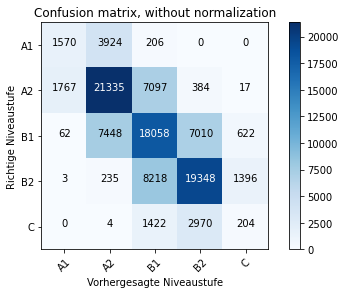

Normalized confusion matrix


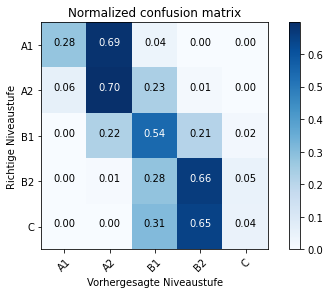

In [36]:
##### word2vec-Embedding
great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])
for i in tqdm(range(100)):
  predicted_targets, true_targets, acc, kappa = evaluate_model(input, target,'knn')
  great_acc.append(acc)
  great_kappa.append(kappa)
  all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
  all_true_targets = np.append(all_true_targets, true_targets)
word2vec = {'name': 'word2vec',
             'acc':mean(great_acc),
             'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

#Auswertung

In [ ]:
results = pd.DataFrame([pos,word,word2vec] ,columns=['name','acc','acc_std','qwk','qwk_std'])
results.sort_values('qwk')

,name,acc,qwk
2,ling + lin. Re,64.272778,0.773192
5,ling + rfr,64.858103,0.782744
3,ling + log. Re,64.765683,0.783965
4,ling + rfk,67.370239,0.802469
1,ling + svr,67.174197,0.802925
0,ling + svc,67.468260,0.803174


In [ ]:
results.to_excel('/content/drive/MyDrive/Masterarbeit/Data/2_2_CNN_Embeddings.xlsx', engine='xlsxwriter', index=False)  